# A. Data loading and feature engineering

## -- A.1 -- datasets conversion

### --- A.1.1 --- mat to json functions

In [16]:
import os
import numpy as np
import pandas as pd
import scipy.io
import json
import random
from datetime import datetime

### --- A.1.2 --- string json to real json

In [8]:
def convert_string_json(input_root: str, subfolders=None):
    """
    Convert double-encoded JSON files inside specific subfolders of input_root,
    and save them as decoded JSONs in input_root/json/ with original filenames.

    Parameters:
    - input_root: root folder containing subfolders with JSON files
    - subfolders: list of subfolder names (relative to input_root) to process
    """
    output_dir = os.path.join(input_root, "json")
    os.makedirs(output_dir, exist_ok=True)

    if subfolders is None:
        subfolders = next(os.walk(input_root))[1]  # all immediate subfolders

    for sub in subfolders:
        sub_path = os.path.join(input_root, sub)
        if not os.path.isdir(sub_path):
            print(f"⚠️ Skipped: {sub_path} (not a folder)")
            continue

        for fname in os.listdir(sub_path):
            if not fname.endswith(".json"):
                continue

            fpath = os.path.join(sub_path, fname)
            try:
                with open(fpath, "r") as f:
                    raw = json.load(f)
                parsed = json.loads(raw)  # double decode

                output_path = os.path.join(output_dir, fname)
                with open(output_path, "w") as out_f:
                    json.dump(parsed, out_f, indent=2)

                print(f"✅ Converted and saved: {fname}")

            except Exception as e:
                print(f"❌ Failed to convert {fname}: {e}")

In [4]:
def convert_mat_to_json(input_path, output_path, subfolders=True):
    os.makedirs(output_path, exist_ok=True)

    def mat_to_dict(mat_obj):
        def _check_keys(obj):
            if isinstance(obj, scipy.io.matlab.mat_struct):
                return _todict(obj)
            elif isinstance(obj, np.ndarray):
                return [_check_keys(el) for el in obj]
            else:
                return obj

        def _todict(matobj):
            d = {}
            for fieldname in matobj._fieldnames:
                d[fieldname] = _check_keys(getattr(matobj, fieldname))
            return d

        return {key: _check_keys(val) for key, val in mat_obj.items() if not key.startswith("__")}

    files_found = False

    if subfolders:
        walker = os.walk(input_path)
    else:
        walker = [(input_path, [], os.listdir(input_path))]

    for root, _, files in walker:
        for file in files:
            if file.endswith(".mat"):
                files_found = True
                mat_path = os.path.join(root, file)
                battery_id = os.path.splitext(file)[0]

                try:
                    mat_data = scipy.io.loadmat(mat_path, struct_as_record=False, squeeze_me=True)
                    nested_dict = mat_to_dict(mat_data)

                    json_output_path = os.path.join(output_path, f"{battery_id}.json")
                    with open(json_output_path, "w") as f:
                        json.dump(nested_dict, f, indent=2, default=str)

                    print(f"✅ Converted: {battery_id} -> {json_output_path}")

                except Exception as e:
                    print(f"❌ Failed to convert {file}: {e}")

    if not files_found:
        print(f"❌ No matching '.mat' files found in '{input_path}' (subfolders={subfolders}).")

In [5]:
def print_json_tree(obj, indent=0, max_depth=5, show_samples=True, sample_size=3):
    """
    Recursively print structure of JSON object, string, or file content with sample values.
    
    Parameters:
    obj - JSON object, string, or file path
    indent - Current indentation level (for recursion)
    max_depth - Maximum depth to recurse
    show_samples - Whether to show sample values
    sample_size - Number of sample items to show from lists
    """
    # Case 1: obj is a file path
    if isinstance(obj, str) and os.path.isfile(obj):
        try:
            with open(obj, 'r') as f:
                content = f.read()
                try:
                    obj = json.loads(content)
                except json.JSONDecodeError:
                    print("File contains an invalid JSON string.")
                    return
        except Exception as e:
            print(f"Error reading file: {e}")
            return
    # Case 2: obj is a JSON string - only try to parse it if it looks like JSON
    elif isinstance(obj, str) and obj.strip().startswith(("{", "[")):
        try:
            obj = json.loads(obj)
        except json.JSONDecodeError:
            # If it's not valid JSON, just treat it as a regular string
            pass

    # Now recursively print the structure
    prefix = "    " * indent
    
    # Handle different types
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{prefix}├── {key}")
            if indent < max_depth:
                print_json_tree(value, indent + 1, max_depth, show_samples, sample_size)
    elif isinstance(obj, list):
        count = len(obj)
        print(f"{prefix}├── [list] ({count} items)")
        
        if count > 0 and show_samples:
            # Get sample indices - first, middle, and last or random if large list
            sample_indices = [0]
            if count > 1:
                if count <= sample_size:
                    # For small lists, just show all items up to sample_size
                    sample_indices = list(range(min(count, sample_size)))
                else:
                    # For large lists, show first, last, and some samples in between
                    middle = count // 2
                    if sample_size == 2:
                        sample_indices = [0, count-1]
                    elif sample_size == 3:
                        sample_indices = [0, middle, count-1]
                    else:
                        # For larger sample sizes, add some random indices
                        sample_indices = [0, middle, count-1]
                        while len(sample_indices) < sample_size:
                            random_idx = random.randint(1, count-2)
                            if random_idx not in sample_indices:
                                sample_indices.append(random_idx)
                        sample_indices.sort()
            
            # Show sample values
            for idx in sample_indices:
                if idx < count:  # Safety check
                    sample_item = obj[idx]
                    if not isinstance(sample_item, (dict, list)):
                        sample_value = str(sample_item)
                        if len(sample_value) > 50:
                            sample_value = sample_value[:47] + "..."
                        print(f"{prefix}│   ├── Sample[{idx}]: {sample_value}")
        
        if count > 0 and indent < max_depth:
            print_json_tree(obj[0], indent + 1, max_depth, show_samples, sample_size)
    else:
        # For primitive types, print the type and sample value
        type_name = type(obj).__name__
        if show_samples:
            sample_value = str(obj)
            if len(sample_value) > 50:
                sample_value = sample_value[:47] + "..."
            print(f"{prefix}├── {type_name} (Sample: {sample_value})")
        else:
            print(f"{prefix}├── {type_name}")

### --- A.1.2 --- conversion

In [6]:
# ==== Convert Nasa Dataset ====

convert_mat_to_json(
    input_path="../Datasets/5.+Battery+Data+Set/5. Battery Data Set",
    output_path="../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json",
    subfolders= True
)

✅ Converted: B0005 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0005.json
✅ Converted: B0006 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0006.json
✅ Converted: B0007 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0007.json
✅ Converted: B0018 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0018.json
✅ Converted: B0025 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0025.json
✅ Converted: B0026 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0026.json
✅ Converted: B0027 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0027.json
✅ Converted: B0028 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0028.json
✅ Converted: B0025 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0025.json
✅ Converted: B0026 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0026.json
✅ Converted: B0027 -> ../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json\B0027.json
✅ Converte

In [7]:
# ==== Convert Oxford Dataset ====

convert_mat_to_json(
    input_path="../Datasets/Oxford Battery Degradation Dataset 1",
    output_path="../Datasets/Oxford Battery Degradation Dataset 1/json",
    subfolders= False
)

✅ Converted: ExampleDC_C1 -> ../Datasets/Oxford Battery Degradation Dataset 1/json\ExampleDC_C1.json
✅ Converted: Oxford_Battery_Degradation_Dataset_1 -> ../Datasets/Oxford Battery Degradation Dataset 1/json\Oxford_Battery_Degradation_Dataset_1.json


In [9]:
# ==== Convert ISU-ILCC Dataset ====

convert_string_json("../Datasets/RPT_json", subfolders=["Release 1.0", "Release 2.0"])

✅ Converted and saved: G10C1.json
✅ Converted and saved: G10C2.json
✅ Converted and saved: G10C3.json
✅ Converted and saved: G10C4.json
✅ Converted and saved: G11C1.json
✅ Converted and saved: G11C2.json
✅ Converted and saved: G11C3.json
✅ Converted and saved: G11C4.json
✅ Converted and saved: G12C1.json
✅ Converted and saved: G12C2.json
✅ Converted and saved: G12C3.json
✅ Converted and saved: G12C4.json
✅ Converted and saved: G13C1.json
✅ Converted and saved: G13C2.json
✅ Converted and saved: G13C3.json
✅ Converted and saved: G13C4.json
✅ Converted and saved: G14C1.json
✅ Converted and saved: G14C2.json
✅ Converted and saved: G14C3.json
✅ Converted and saved: G14C4.json
✅ Converted and saved: G16C1.json
✅ Converted and saved: G16C2.json
✅ Converted and saved: G16C3.json
✅ Converted and saved: G16C4.json
✅ Converted and saved: G17C1.json
✅ Converted and saved: G17C2.json
✅ Converted and saved: G17C3.json
✅ Converted and saved: G17C4.json
✅ Converted and saved: G18C1.json
✅ Converted an

### --- A.1.3 --- check structure

In [10]:
# ==== Nasa structure check ====

json_path_nasa = "../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json/B0005.json"
with open(json_path_nasa, "r") as f:
    json_data_nasa = json.load(f)

print("Sample Nasa Dataset Tree Structure:\n")
print_json_tree(json_data_nasa)

Sample Nasa Dataset Tree Structure:

├── B0005
    ├── cycle
        ├── [list] (616 items)
            ├── type
                ├── str (Sample: charge)
            ├── ambient_temperature
                ├── int (Sample: 24)
            ├── time
                ├── [list] (6 items)
                │   ├── Sample[0]: 2008.0
                │   ├── Sample[3]: 13.0
                │   ├── Sample[5]: 17.921
                    ├── float (Sample: 2008.0)
            ├── data
                ├── Voltage_measured
                    ├── [list] (789 items)
                    │   ├── Sample[0]: 3.873017221300996
                    │   ├── Sample[394]: 4.205472548937624
                    │   ├── Sample[788]: 4.191077562801999
                ├── Current_measured
                    ├── [list] (789 items)
                    │   ├── Sample[0]: -0.001200660698297908
                    │   ├── Sample[394]: 0.3956316560725337
                    │   ├── Sample[788]: -0.002892444158252333
    

In [11]:
# ==== Oxford structure check ====

json_path_oxford = "../Datasets/Oxford Battery Degradation Dataset 1/json/Oxford_Battery_Degradation_Dataset_1.json"
with open(json_path_oxford, "r") as f:
    json_data_oxford = json.load(f)

print("Sample Dataset Tree Structure:\n")
print_json_tree(json_data_oxford)

Sample Dataset Tree Structure:

├── Cell1
    ├── cyc0000
        ├── C1ch
            ├── t
                ├── [list] (3510 items)
                │   ├── Sample[0]: 735954.8589655256
                │   ├── Sample[1755]: 735954.8792780254
                │   ├── Sample[3509]: 735954.8995751016
                    ├── float (Sample: 735954.8589655256)
            ├── v
                ├── [list] (3510 items)
                │   ├── Sample[0]: 2.7192132
                │   ├── Sample[1755]: 3.8301208
                │   ├── Sample[3509]: 4.1999769
                    ├── float (Sample: 2.7192132)
            ├── q
                ├── [list] (3510 items)
                │   ├── Sample[0]: -4.882955593532986e-05
                │   ├── Sample[1755]: 362.2047490158623
                │   ├── Sample[3509]: 724.1208914093187
                    ├── float (Sample: -4.882955593532986e-05)
            ├── T
                ├── [list] (3510 items)
                │   ├── Sample[0]: 41.295536
 

In [12]:
# ==== isu-ilcc structure check ====

json_path_isu = "../Datasets/RPT_json/json/G26C3.json"
with open(json_path_isu, "r") as f:
    json_data_isu = json.load(f)

print("Sample Dataset Tree Structure:\n")
print_json_tree(json_data_isu)

Sample Dataset Tree Structure:

├── capacity_discharge_C_5
    ├── [list] (67 items)
    │   ├── Sample[0]: 0.285875982222222
    │   ├── Sample[33]: 0.25650976
    │   ├── Sample[66]: 0.140604186666667
        ├── float (Sample: 0.285875982222222)
├── capacity_discharge_C_2
    ├── [list] (67 items)
    │   ├── Sample[0]: 0.279455777777778
    │   ├── Sample[33]: 0.2508826
    │   ├── Sample[66]: 0.109103877777778
        ├── float (Sample: 0.279455777777778)
├── capacity_charge_C_5
    ├── [list] (67 items)
    │   ├── Sample[0]: 0.285302542222222
    │   ├── Sample[33]: 0.256026755555556
    │   ├── Sample[66]: 0.134349724444444
        ├── float (Sample: 0.285302542222222)
├── capacity_charge_C_2
    ├── [list] (67 items)
    │   ├── Sample[0]: 0.286363733333333
    │   ├── Sample[33]: 0.256007306666667
    │   ├── Sample[66]: 0.138188728888889
        ├── float (Sample: 0.286363733333333)
├── QV_discharge_C_5
    ├── Q
        ├── [list] (67 items)
            ├── [list] (4140 ite

## -- A.2 -- loading and engineering

In [13]:
def compute_derivatives_over_time(y, t):
    return np.gradient(y, t)

### --- A.2.1 --- Nasa dataset

In [14]:
def load_nasa_dataset_with_q_ah(path, initial_capacity=2.0, verbose=False):
    rows = []
    success_files = 0
    failed_files = 0
    failed_cycles = 0
    processed_cycles = 0

    for battery_file in os.listdir(path):
        if not battery_file.endswith(".json"):
            continue

        battery_id = battery_file.split(".")[0]
        file_path = os.path.join(path, battery_file)

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            failed_files += 1
            if verbose:
                print(f"❌ Failed to load {battery_file}: {e}")
            continue

        print(f"\n📦 Loading data for {battery_id}...")

        battery_data = data.get(battery_id, {})
        cycles = battery_data.get("cycle", [])

        for idx, cycle in enumerate(cycles):
            if cycle.get("type") != "discharge":
                continue

            print(f"  🔄 Processing cycle {idx}...")

            try:
                time = np.array(cycle["data"].get("Time", []))
                current = np.array(cycle["data"].get("Current_measured", []))
                voltage = np.array(cycle["data"].get("Voltage_measured", []))
                temp = np.array(cycle["data"].get("Temperature_measured", []))
                ambient_temp = cycle.get("ambient_temperature", None)

                if len(time) < 2 or not all(len(arr) == len(time) for arr in [current, voltage, temp]):
                    raise ValueError("Mismatched or too short arrays")

                sorted_indices = np.argsort(time)
                time = time[sorted_indices]
                current = current[sorted_indices]
                voltage = voltage[sorted_indices]
                temp = temp[sorted_indices]

                q_coulomb = np.trapz(current, time)
                q_ah = -q_coulomb / 3600  # discharge → flip sign to positive

                dq_dt = compute_derivatives_over_time(q_ah * 1000 * np.ones_like(time), time)
                dv_dt = compute_derivatives_over_time(voltage, time)
                dT_dt = compute_derivatives_over_time(temp, time)

                cap_reported = cycle["data"].get("Capacity", None)
                soh = (cap_reported or 0) / initial_capacity

                row = {
                    "battery_id": battery_id,
                    "cycle_idx": idx,
                    "rated_capacity": initial_capacity,
                    "ambient_temperature": ambient_temp,
                    "capacity": cap_reported,
                    "soh": soh,
                    "computed_q_max_Ah": q_ah,
                    "capacity_reported_Ah": cap_reported,
                    "duration": time[-1] - time[0],
                    "q_gap_abs": q_ah - (cap_reported or 0),
                    "q_gap_pct": 100 * (q_ah - (cap_reported or 0)) / (cap_reported or 1),
                    "dv_dt_mean": np.mean(dv_dt),
                    "dv_dt_std": np.std(dv_dt),
                    "dv_dt_max": np.max(dv_dt),
                    "dv_dt_min": np.min(dv_dt),
                    "dT_dt_mean": np.mean(dT_dt),
                    "dT_dt_std": np.std(dT_dt),
                    "dT_dt_max": np.max(dT_dt),
                    "dT_dt_min": np.min(dT_dt),
                    "dq_dt_mean": np.mean(dq_dt),
                    "dq_dt_std": np.std(dq_dt),
                    "dq_dt_max": np.max(dq_dt),
                    "dq_dt_min": np.min(dq_dt),
                    "test_condition": "nasa_room_ambient"
                }

                rows.append(row)
                processed_cycles += 1

            except Exception as e:
                failed_cycles += 1
                if verbose:
                    print(f"⚠️ Error in {battery_id} cycle {idx}: {e}")
                continue

        success_files += 1

    if verbose:
        print(f"\n✅ Files processed: {success_files}")
        print(f"❌ Files failed: {failed_files}")
        print(f"✅ Cycles processed: {processed_cycles}")
        print(f"⚠️ Cycles failed: {failed_cycles}")

    print("\n✅ Finished loading all batteries and cycles.")
    return pd.DataFrame(rows)

In [17]:
nasa_path = "../Datasets/5.+Battery+Data+Set/5. Battery Data Set/json"
nasa_df = load_nasa_dataset_with_q_ah(nasa_path, verbose=True)

nasa_df.to_csv("../Datasets/nasa_dataset.csv", index=False)
nasa_df.head()


📦 Loading data for B0005...
  🔄 Processing cycle 1...
  🔄 Processing cycle 3...
  🔄 Processing cycle 5...
  🔄 Processing cycle 7...
  🔄 Processing cycle 9...
  🔄 Processing cycle 11...
  🔄 Processing cycle 13...
  🔄 Processing cycle 15...
  🔄 Processing cycle 17...
  🔄 Processing cycle 19...
  🔄 Processing cycle 21...
  🔄 Processing cycle 24...
  🔄 Processing cycle 26...
  🔄 Processing cycle 28...
  🔄 Processing cycle 30...
  🔄 Processing cycle 32...
  🔄 Processing cycle 34...
  🔄 Processing cycle 36...
  🔄 Processing cycle 38...
  🔄 Processing cycle 41...
  🔄 Processing cycle 45...
  🔄 Processing cycle 49...
  🔄 Processing cycle 53...
  🔄 Processing cycle 57...
  🔄 Processing cycle 61...
  🔄 Processing cycle 65...
  🔄 Processing cycle 69...
  🔄 Processing cycle 73...
  🔄 Processing cycle 77...
  🔄 Processing cycle 81...
  🔄 Processing cycle 85...
  🔄 Processing cycle 89...
  🔄 Processing cycle 93...
  🔄 Processing cycle 97...
  🔄 Processing cycle 101...
  🔄 Processing cycle 105...
  

battery_id  cycle_idx  rated_capacity  ambient_temperature  capacity  \
0      B0005          1             2.0                   24  1.856487   
1      B0005          3             2.0                   24  1.846327   
2      B0005          5             2.0                   24  1.835349   
3      B0005          7             2.0                   24  1.835263   
4      B0005          9             2.0                   24  1.834646   

        soh  computed_q_max_Ah capacity_reported_Ah  duration  q_gap_abs  ...  \
0  0.928244           1.862192             1.856487  3690.234   0.005705  ...   
1  0.923164           1.851986             1.846327  3672.344   0.005658  ...   
2  0.917675           1.840993             1.835349  3651.641   0.005644  ...   
3  0.917631           1.840881             1.835263  3631.563   0.005618  ...   
4  0.917323           1.840325             1.834646  3629.172   0.005680  ...   

   dv_dt_min  dT_dt_mean  dT_dt_std  dT_dt_max  dT_dt_min    dq_dt_mean  \
0  -0.006445    0.002755   0.005795   0.011200  -0.016846  2.164090e-16   
1  -0.007408    0.002709   0.005664   0.010492  -0.016217 -4.712783e-16   
2  -0.006764    0.002669   0.005607   0.010571  -0.016199  1.457524e-16   
3  -0.007604    0.002744   0.005538   0.010650  -0.016200  7.325183e-17   
4  -0.008324    0.002759   0.005523   0.010878  -0.015967  1.465037e-16   

      dq_dt_std     dq_dt_max     dq_dt_min     test_condition  
0  5.767974e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient  
1  4.976330e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient  
2  5.799726e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient  
3  5.904843e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient  
4  5.990997e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient  

[5 rows x 24 columns]

### --- A.2.2 --- Oxford dataset

In [18]:
def load_oxford_dataset_with_q_ah(path, initial_capacity=0.74, verbose=False):
    """
    Load Oxford dataset from JSON file and compute q-based features in NASA-compatible format.
    """
    rows = []
    processed_cycles = 0
    failed_cycles = 0
    processed_files = 0
    failed_files = 0

    # Load JSON data
    try:
        with open(path, "r") as f:
            data = json.load(f)
        processed_files += 1
    except Exception as e:
        failed_files += 1
        print(f"❌ Failed to load JSON: {e}")
        return pd.DataFrame()

    for cell_id, cycles in data.items():
        print(f"\n📦 Loading data for {cell_id}...")
        for cyc_id, cycle in cycles.items():
            if "C1dc" not in cycle:
                continue

            print(f"  🔄 Processing {cyc_id}...")

            try:
                c1dc = cycle["C1dc"]
                q = np.array(c1dc.get("q", []))
                t_raw = np.array(c1dc.get("t", []))
                v = np.array(c1dc.get("v", []))
                T = np.array(c1dc.get("T", []))

                if len(q) < 2 or not all(len(arr) == len(t_raw) for arr in [q, v, T]):
                    raise ValueError("Mismatched or too short arrays")

                t = (t_raw - t_raw[0]) * 86400  # Convert MATLAB datenum to seconds

                dv_dt = np.gradient(v, t)
                dT_dt = np.gradient(T, t)
                dq_dt = np.gradient(q, t)

                q_ah = abs(min(q)) / 1000  # in Ah

                row = {
                    "battery_id": f"Oxford_{cell_id}",
                    "cycle_idx": int(cyc_id.replace("cyc", "")),
                    "rated_capacity": initial_capacity,
                    "ambient_temperature": 40.0,
                    "capacity": q_ah,
                    "soh": q_ah / initial_capacity,
                    "computed_q_max_Ah": q_ah,
                    "capacity_reported_Ah": None,
                    "duration": max(t) - min(t),
                    "q_gap_abs": 0,
                    "q_gap_pct": 0,
                    "dv_dt_mean": np.mean(dv_dt),
                    "dv_dt_std": np.std(dv_dt),
                    "dv_dt_max": np.max(dv_dt),
                    "dv_dt_min": np.min(dv_dt),
                    "dT_dt_mean": np.mean(dT_dt),
                    "dT_dt_std": np.std(dT_dt),
                    "dT_dt_max": np.max(dT_dt),
                    "dT_dt_min": np.min(dT_dt),
                    "dq_dt_mean": np.mean(dq_dt),
                    "dq_dt_std": np.std(dq_dt),
                    "dq_dt_max": np.max(dq_dt),
                    "dq_dt_min": np.min(dq_dt),
                    "test_condition": "oxford_40C_1C"
                }

                rows.append(row)
                processed_cycles += 1

            except Exception as e:
                failed_cycles += 1
                if verbose:
                    print(f"    ⚠️ Failed {cell_id} {cyc_id}: {e}")
                continue

    print(f"\n✅ Files processed: {processed_files}")
    print(f"❌ Files failed: {failed_files}")
    print(f"✅ Cycles processed: {processed_cycles}")
    print(f"⚠️ Cycles failed: {failed_cycles}")
    print("\n✅ Finished loading all batteries and cycles.")

    return pd.DataFrame(rows)


In [19]:
oxford_path = "../Datasets/Oxford Battery Degradation Dataset 1/json/Oxford_Battery_Degradation_Dataset_1.json"
oxford_df = load_oxford_dataset_with_q_ah(path=oxford_path, initial_capacity=0.74,verbose=True)

oxford_df.to_csv("../Datasets/oxford_dataset.csv", index=False)
oxford_df.head()


📦 Loading data for Cell1...
  🔄 Processing cyc0000...
  🔄 Processing cyc0100...
  🔄 Processing cyc0200...
  🔄 Processing cyc0300...
  🔄 Processing cyc0400...
  🔄 Processing cyc0500...
  🔄 Processing cyc0600...
  🔄 Processing cyc0700...
  🔄 Processing cyc0800...
  🔄 Processing cyc0900...
  🔄 Processing cyc1000...
  🔄 Processing cyc1100...
  🔄 Processing cyc1200...
  🔄 Processing cyc1300...
  🔄 Processing cyc1400...
  🔄 Processing cyc1600...
  🔄 Processing cyc1800...
  🔄 Processing cyc1900...
  🔄 Processing cyc2000...
  🔄 Processing cyc2100...
  🔄 Processing cyc2200...
  🔄 Processing cyc2300...
  🔄 Processing cyc2400...
  🔄 Processing cyc2500...
  🔄 Processing cyc2600...
  🔄 Processing cyc2700...
  🔄 Processing cyc2800...
  🔄 Processing cyc2900...
  🔄 Processing cyc3000...
  🔄 Processing cyc3100...
  🔄 Processing cyc3200...
  🔄 Processing cyc3300...
  🔄 Processing cyc3500...
  🔄 Processing cyc3600...
  🔄 Processing cyc3700...
  🔄 Processing cyc3800...
  🔄 Processing cyc3900...
  🔄 Proce

battery_id  cycle_idx  rated_capacity  ambient_temperature  capacity  \
0  Oxford_Cell1          0            0.74                 40.0  0.739111   
1  Oxford_Cell1        100            0.74                 40.0  0.730193   
2  Oxford_Cell1        200            0.74                 40.0  0.725747   
3  Oxford_Cell1        300            0.74                 40.0  0.722843   
4  Oxford_Cell1        400            0.74                 40.0  0.718367   

        soh  computed_q_max_Ah capacity_reported_Ah     duration  q_gap_abs  \
0  0.998799           0.739111                 None  3606.330147          0   
1  0.986747           0.730193                 None  3563.544049          0   
2  0.980739           0.725747                 None  3542.140735          0   
3  0.976815           0.722843                 None  3528.063764          0   
4  0.970766           0.718367                 None  3505.889715          0   

   ...  dv_dt_min  dT_dt_mean  dT_dt_std  dT_dt_max  dT_dt_min  dq_dt_mean  \
0  ...  -0.015480    0.000298   0.025866   0.113391  -0.087363   -0.204947   
1  ...  -0.016161    0.000172   0.025882   0.099868  -0.136606   -0.204905   
2  ...  -0.015961    0.000032   0.027449   0.087362  -0.428081   -0.204888   
3  ...  -0.016969   -0.000404   0.037050   0.099848  -1.173595   -0.204882   
4  ...  -0.016000    0.000263   0.025869   0.087381  -0.093615   -0.204901   

   dq_dt_std  dq_dt_max  dq_dt_min  test_condition  
0   0.000190  -0.194832  -0.204965   oxford_40C_1C  
1   0.000194  -0.194814  -0.204949   oxford_40C_1C  
2   0.000192  -0.194795  -0.204939   oxford_40C_1C  
3   0.000192  -0.194722  -0.204898   oxford_40C_1C  
4   0.000193  -0.194788  -0.204932   oxford_40C_1C  

[5 rows x 24 columns]

### --- A.2.3. --- ISU-ILCC dataset

In [20]:
def load_all_json_files(directory_path):
    """Load all JSON files in a directory and return a list of (filename, json_data)."""
    data_list = []
    filenames = [f for f in os.listdir(directory_path) if f.endswith(".json")]
    total = len(filenames)
    
    print(f"\n🔍 Found {total} JSON files. Starting load...\n")

    for i, filename in enumerate(filenames, 1):
        full_path = os.path.join(directory_path, filename)
        try:
            with open(full_path, 'r') as f:
                json_data = json.load(f)
                data_list.append((filename.split('.')[0], json_data))
                print(f"[{i:3}/{total}] ✅ Loaded: {filename}")
        except Exception as e:
            print(f"[{i:3}/{total}] ❌ Failed: {filename} → {e}")

    print(f"\n✅ Finished loading {len(data_list)} files.")
    return data_list

In [21]:
def compute_cycle_metrics_debug(battery_id, data, error_log, rated_capacity=0.25, ambient_temp=30.0):
    if "QV_discharge_C_5" not in data:
        return []

    Q_cycles = data["QV_discharge_C_5"].get("Q", [])
    V_cycles = data["QV_discharge_C_5"].get("V", [])
    t_cycles = data["QV_discharge_C_5"].get("t", [])

    n_cycles = min(len(Q_cycles), len(V_cycles), len(t_cycles))
    results = []

    for cycle_idx in range(n_cycles):
        try:
            Q = Q_cycles[cycle_idx]
            V = V_cycles[cycle_idx]
            t = t_cycles[cycle_idx]

            if not Q or not V or not t:
                error_log.append((battery_id, cycle_idx, "Missing Q/V/t list"))
                continue

            if len(t) < 2:
                error_log.append((battery_id, cycle_idx, "Too few timestamps"))
                continue

            t_cleaned = [ti.split('.')[0] + '.' + ti.split('.')[1][:6] for ti in t]
            t_parsed = [datetime.strptime(ti, "%Y-%m-%dT%H:%M:%S.%f") for ti in t_cleaned]
            time_sec = [(tp - t_parsed[0]).total_seconds() for tp in t_parsed]

            if len(set(time_sec)) < 2:
                error_log.append((battery_id, cycle_idx, "Non-unique timestamps"))
                continue

            dq_dt = np.gradient(Q, time_sec)
            dv_dt = np.abs(np.gradient(V, time_sec))

            q_ah = max(Q)
            capacity = q_ah
            soh = capacity / rated_capacity
            q_gap_abs = q_ah - capacity
            q_gap_pct = 0.0

            row = {
                "battery_id": battery_id,
                "cycle_idx": cycle_idx,
                "rated_capacity": rated_capacity,
                "ambient_temperature": ambient_temp,
                "capacity": capacity,
                "soh": soh,
                "computed_q_max_Ah": q_ah,
                "capacity_reported_Ah": capacity,
                "duration": time_sec[-1],
                "q_gap_abs": q_gap_abs,
                "q_gap_pct": q_gap_pct,
                "dv_dt_mean": np.nanmean(dv_dt),
                "dv_dt_std": np.nanstd(dv_dt),
                "dv_dt_max": np.nanmax(dv_dt),
                "dv_dt_min": np.nanmin(dv_dt),
                "dT_dt_mean": None,
                "dT_dt_std": None,
                "dT_dt_max": None,
                "dT_dt_min": None,
                "dq_dt_mean": np.nanmean(dq_dt),
                "dq_dt_std": np.nanstd(dq_dt),
                "dq_dt_max": np.nanmax(dq_dt),
                "dq_dt_min": np.nanmin(dq_dt),
                "test_condition": "isu_room_ambient"
            }
            results.append(row)

        except Exception as e:
            error_log.append((battery_id, cycle_idx, str(e)))

    return results


In [22]:
def process_isu_data(path, show_errors=True):
    import warnings

    error_log = []
    all_metrics = []

    all_data = load_all_json_files(path)

    total = len(all_data)
    print(f"\n🔄 Starting processing on {total} battery files...\n")

    for i, (battery_id, data) in enumerate(all_data, 1):
        start_err_len = len(error_log)

        # Suppress gradient warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            metrics = compute_cycle_metrics_debug(battery_id, data, error_log)

        n_success = len(metrics)
        n_fail = len(error_log) - start_err_len

        if n_success == 0:
            print(f"[{i:3}/{total}] → {battery_id}: ❌ skipped (0 valid cycles)")
            continue  # Skip adding to all_metrics

        all_metrics.extend(metrics)

        status = f"[{i:3}/{total}] → {battery_id}: "
        status += f"✅ {n_success} cycles" if n_fail == 0 else f"⚠️  {n_success} success, {n_fail} failed"
        print(status)

        if n_fail and show_errors:
            for err in error_log[start_err_len:]:
                print(f"     └─ [Cycle {err[1]}] {err[2]}")

    print(f"\n✅ Done. {len(all_metrics)} total cycles processed.")
    print(f"❌ Total failed cycles: {len(error_log)}\n")

    df_metrics = pd.DataFrame(all_metrics)
    df_errors = pd.DataFrame(error_log, columns=["battery_id", "cycle_idx", "error"])
    return df_metrics, df_errors


In [23]:
isu_path = "../Datasets/RPT_json/json"
isu_df, error_log_isu = process_isu_data(isu_path, show_errors=True)

isu_df.to_csv("../Datasets/isu_ilcc_dataset.csv", index=False)
isu_df.head()


🔍 Found 251 JSON files. Starting load...

[  1/251] ✅ Loaded: G10C1.json
[  2/251] ✅ Loaded: G10C2.json
[  3/251] ✅ Loaded: G10C3.json
[  4/251] ✅ Loaded: G10C4.json
[  5/251] ✅ Loaded: G11C1.json
[  6/251] ✅ Loaded: G11C2.json
[  7/251] ✅ Loaded: G11C3.json
[  8/251] ✅ Loaded: G11C4.json
[  9/251] ✅ Loaded: G12C1.json
[ 10/251] ✅ Loaded: G12C2.json
[ 11/251] ✅ Loaded: G12C3.json
[ 12/251] ✅ Loaded: G12C4.json
[ 13/251] ✅ Loaded: G13C1.json
[ 14/251] ✅ Loaded: G13C2.json
[ 15/251] ✅ Loaded: G13C3.json
[ 16/251] ✅ Loaded: G13C4.json
[ 17/251] ✅ Loaded: G14C1.json
[ 18/251] ✅ Loaded: G14C2.json
[ 19/251] ✅ Loaded: G14C3.json
[ 20/251] ✅ Loaded: G14C4.json
[ 21/251] ✅ Loaded: G16C1.json
[ 22/251] ✅ Loaded: G16C2.json
[ 23/251] ✅ Loaded: G16C3.json
[ 24/251] ✅ Loaded: G16C4.json
[ 25/251] ✅ Loaded: G17C1.json
[ 26/251] ✅ Loaded: G17C2.json
[ 27/251] ✅ Loaded: G17C3.json
[ 28/251] ✅ Loaded: G17C4.json
[ 29/251] ✅ Loaded: G18C1.json
[ 30/251] ✅ Loaded: G18C2.json
[ 31/251] ✅ Loaded: G18C3.j

battery_id  cycle_idx  rated_capacity  ambient_temperature  capacity  \
0      G10C1          0            0.25                 30.0  0.282741   
1      G10C1          1            0.25                 30.0  0.262946   
2      G10C1          2            0.25                 30.0  0.251615   
3      G10C1          3            0.25                 30.0  0.245625   
4      G10C1          4            0.25                 30.0  0.242721   

        soh  computed_q_max_Ah  capacity_reported_Ah  duration  q_gap_abs  \
0  1.130966           0.282741              0.282741   20357.0        0.0   
1  1.051783           0.262946              0.262946   18932.0        0.0   
2  1.006461           0.251615              0.251615   18116.0        0.0   
3  0.982500           0.245625              0.245625   17685.0        0.0   
4  0.970883           0.242721              0.242721   17476.0        0.0   

   ...  dv_dt_min  dT_dt_mean  dT_dt_std  dT_dt_max  dT_dt_min dq_dt_mean  \
0  ...        inf        None       None       None       None        inf   
1  ...        0.0        None       None       None       None   0.000014   
2  ...        0.0        None       None       None       None   0.000014   
3  ...        0.0        None       None       None       None   0.000014   
4  ...        0.0        None       None       None       None   0.000014   

      dq_dt_std dq_dt_max dq_dt_min    test_condition  
0           NaN       inf       inf  isu_room_ambient  
1  1.651274e-07  0.000021  0.000011  isu_room_ambient  
2  3.001256e-07  0.000018  0.000007  isu_room_ambient  
3  1.261603e-07  0.000017  0.000011  isu_room_ambient  
4  8.620749e-08  0.000016  0.000011  isu_room_ambient  

[5 rows x 24 columns]

## -- A.3 -- Load data from saved csv, merge and save to csv

In [24]:
nasa_df_from_csv = pd.read_csv("../Datasets/nasa_dataset.csv")
oxford_df_from_csv = pd.read_csv("../Datasets/oxford_dataset.csv")
isu_df_from_csv = pd.read_csv("../Datasets/isu_ilcc_dataset.csv")

print("NASA Dataset:")
nasa_df_from_csv.info()
print("\nOxford Dataset:")
oxford_df_from_csv.info()
print("\nISU-ILCC Dataset:")
isu_df_from_csv.info()

NASA Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794 entries, 0 to 2793
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   battery_id            2794 non-null   object 
 1   cycle_idx             2794 non-null   int64  
 2   rated_capacity        2794 non-null   float64
 3   ambient_temperature   2794 non-null   int64  
 4   capacity              2794 non-null   object 
 5   soh                   2794 non-null   float64
 6   computed_q_max_Ah     2794 non-null   float64
 7   capacity_reported_Ah  2794 non-null   object 
 8   duration              2794 non-null   float64
 9   q_gap_abs             2794 non-null   float64
 10  q_gap_pct             2794 non-null   float64
 11  dv_dt_mean            2794 non-null   float64
 12  dv_dt_std             2794 non-null   float64
 13  dv_dt_max             2794 non-null   float64
 14  dv_dt_min             2794 non-null   float64
 15  dT_dt_m

In [150]:
# Tag each DataFrame with a source label
nasa_df_from_csv["source"] = "nasa"
oxford_df_from_csv["source"] = "oxford"
isu_df_from_csv["source"] = "isu"

# Merge all datasets
df_merged = pd.concat([nasa_df_from_csv, oxford_df_from_csv, isu_df_from_csv], ignore_index=True)

# Attempt to convert object columns to numeric where possible
obj_cols = df_merged.select_dtypes(include='object').columns
for col in obj_cols:
    try:
        df_merged[col] = pd.to_numeric(df_merged[col])
    except:
        pass  # leave column as is if conversion fails

# Force known numeric-like columns
df_merged['capacity'] = pd.to_numeric(df_merged['capacity'], errors='coerce')
df_merged['capacity_reported_Ah'] = pd.to_numeric(df_merged['capacity_reported_Ah'], errors='coerce')

# Save merged dataset
df_merged.to_csv("../Datasets/merged_battery_dataset.csv", index=False)
print("✅ Merged dataset saved as 'merged_battery_dataset.csv'")

df_merged.head()

✅ Merged dataset saved as 'merged_battery_dataset.csv'


battery_id  cycle_idx  rated_capacity  ambient_temperature  capacity  \
0      B0005          1             2.0                 24.0  1.856487   
1      B0005          3             2.0                 24.0  1.846327   
2      B0005          5             2.0                 24.0  1.835349   
3      B0005          7             2.0                 24.0  1.835263   
4      B0005          9             2.0                 24.0  1.834646   

        soh  computed_q_max_Ah  capacity_reported_Ah  duration  q_gap_abs  \
0  0.928244           1.862192              1.856487  3690.234   0.005705   
1  0.923164           1.851986              1.846327  3672.344   0.005658   
2  0.917675           1.840993              1.835349  3651.641   0.005644   
3  0.917631           1.840881              1.835263  3631.563   0.005618   
4  0.917323           1.840325              1.834646  3629.172   0.005680   

   ...  dT_dt_mean  dT_dt_std  dT_dt_max  dT_dt_min    dq_dt_mean  \
0  ...    0.002755   0.005795   0.011200  -0.016846  2.164090e-16   
1  ...    0.002709   0.005664   0.010492  -0.016217 -4.712783e-16   
2  ...    0.002669   0.005607   0.010571  -0.016199  1.457524e-16   
3  ...    0.002744   0.005538   0.010650  -0.016200  7.325183e-17   
4  ...    0.002759   0.005523   0.010878  -0.015967  1.465037e-16   

      dq_dt_std     dq_dt_max     dq_dt_min     test_condition  source  
0  5.767974e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient    nasa  
1  4.976330e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient    nasa  
2  5.799726e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient    nasa  
3  5.904843e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient    nasa  
4  5.990997e-15  1.421085e-14 -1.421085e-14  nasa_room_ambient    nasa  

[5 rows x 25 columns]

# B. EDA

## -- B.1 -- Load from merged saved csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import matplotlib.colors as mcolors

In [157]:
df_merged_from_csv = pd.read_csv("../Datasets/merged_battery_dataset.csv")

# ==== Drop directly unused features ====
df_merged_from_csv = df_merged_from_csv.drop(columns=[
    'battery_id',
    'soh',
    'computed_q_max_Ah',
    'capacity_reported_Ah',
    'q_gap_abs',
    'q_gap_pct',
    'dT_dt_mean',
    'dT_dt_std',
    'dT_dt_max',
    'dT_dt_min',
    'source',
    'test_condition'
])

# Drop rows with any remaining NaNs
df_merged_from_csv.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged_from_csv = df_merged_from_csv.dropna()
df_merged_from_csv = df_merged_from_csv.apply(pd.to_numeric, errors="coerce")

df_merged_from_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6034 entries, 0 to 6853
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cycle_idx            6034 non-null   int64  
 1   rated_capacity       6034 non-null   float64
 2   ambient_temperature  6034 non-null   float64
 3   capacity             6034 non-null   float64
 4   duration             6034 non-null   float64
 5   dv_dt_mean           6034 non-null   float64
 6   dv_dt_std            6034 non-null   float64
 7   dv_dt_max            6034 non-null   float64
 8   dv_dt_min            6034 non-null   float64
 9   dq_dt_mean           6034 non-null   float64
 10  dq_dt_std            6034 non-null   float64
 11  dq_dt_max            6034 non-null   float64
 12  dq_dt_min            6034 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 660.0 KB


In [158]:
nasa_df_from_csv = pd.read_csv("../Datasets/nasa_dataset.csv")
nasa_df_from_csv_increment = nasa_df_from_csv.drop(columns=[
    'battery_id',
    'soh',
    'computed_q_max_Ah',
    'capacity_reported_Ah',
    'q_gap_abs',
    'q_gap_pct',
    'dT_dt_mean',
    'dT_dt_std',
    'dT_dt_max',
    'dT_dt_min',
    'test_condition'
])
nasa_df_from_csv_increment.replace([np.inf, -np.inf], np.nan, inplace=True)
nasa_df_from_csv_increment = nasa_df_from_csv_increment.dropna()
nasa_df_from_csv_increment = nasa_df_from_csv_increment.apply(pd.to_numeric, errors="coerce")

oxford_df_from_csv = pd.read_csv("../Datasets/oxford_dataset.csv")
oxford_df_from_csv_increment = oxford_df_from_csv.drop(columns=[
    'battery_id',
    'soh',
    'computed_q_max_Ah',
    'capacity_reported_Ah',
    'q_gap_abs',
    'q_gap_pct',
    'dT_dt_mean',
    'dT_dt_std',
    'dT_dt_max',
    'dT_dt_min',
    'test_condition'
])
oxford_df_from_csv_increment.replace([np.inf, -np.inf], np.nan, inplace=True)
oxford_df_from_csv_increment = oxford_df_from_csv_increment.dropna()
oxford_df_from_csv_increment = oxford_df_from_csv_increment.apply(pd.to_numeric, errors="coerce")

isu_df_from_csv = pd.read_csv("../Datasets/isu_ilcc_dataset.csv")
isu_df_from_csv_increment = isu_df_from_csv.drop(columns=[
    'battery_id',
    'soh',
    'computed_q_max_Ah',
    'capacity_reported_Ah',
    'q_gap_abs',
    'q_gap_pct',
    'dT_dt_mean',
    'dT_dt_std',
    'dT_dt_max',
    'dT_dt_min',
    'test_condition'
])
isu_df_from_csv_increment.replace([np.inf, -np.inf], np.nan, inplace=True)
isu_df_from_csv_increment = isu_df_from_csv_increment.dropna()
isu_df_from_csv_increment = isu_df_from_csv_increment.apply(pd.to_numeric, errors="coerce")

print("NASA Dataset:")
nasa_df_from_csv_increment.info()

print("\nOxford Dataset:")
oxford_df_from_csv_increment.info()

print("\nISU-ILCC Dataset:")
isu_df_from_csv_increment.info()

NASA Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794 entries, 0 to 2793
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cycle_idx            2794 non-null   int64  
 1   rated_capacity       2794 non-null   float64
 2   ambient_temperature  2794 non-null   int64  
 3   capacity             2769 non-null   float64
 4   duration             2794 non-null   float64
 5   dv_dt_mean           2794 non-null   float64
 6   dv_dt_std            2794 non-null   float64
 7   dv_dt_max            2794 non-null   float64
 8   dv_dt_min            2794 non-null   float64
 9   dq_dt_mean           2794 non-null   float64
 10  dq_dt_std            2794 non-null   float64
 11  dq_dt_max            2794 non-null   float64
 12  dq_dt_min            2794 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 283.9 KB

Oxford Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entri

## -- B.2 -- Anomaly check and charts

In [4]:
def eda_anomaly_check(df):

    print("🔍 Basic Info:")
    print(df.info())

    print("\n🧹 Missing Values:")
    missing = df.isnull().sum()
    if missing.any():
        print(missing[missing > 0].sort_values(ascending=False))
    else:
        print("✅ No missing values.")

    print("\n♾️ Inf/-Inf Values:")
    inf_counts = (df == np.inf).sum() + (df == -np.inf).sum()
    if inf_counts.any():
        print(inf_counts[inf_counts > 0].sort_values(ascending=False))
    else:
        print("✅ No inf/-inf values.")

    print("\n📊 Constant Columns (Zero Variance):")
    zero_var_cols = df.columns[df.nunique(dropna=True) <= 1]
    if len(zero_var_cols) > 0:
        print(list(zero_var_cols))
    else:
        print("✅ No constant columns.")

    print("\n📈 Descriptive Stats:")
    desc = df.describe().T
    print(desc[['min', 'max', 'mean', 'std']])

    print("\n📉 Outlier Check (Z-score > 3):")
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = np.abs(zscore(numeric_df, nan_policy='omit'))
    outlier_mask = (z_scores > 3)
    outlier_counts = pd.DataFrame(outlier_mask, columns=numeric_df.columns).sum()
    outliers = outlier_counts[outlier_counts > 0].sort_values(ascending=False)
    if not outliers.empty:
        print(outliers)
    else:
        print("✅ No major outliers detected.")

    print("\n✅ Anomaly check complete.")

In [5]:
eda_anomaly_check(df_merged_from_csv)

🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6034 entries, 0 to 6853
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cycle_idx            6034 non-null   int64  
 1   rated_capacity       6034 non-null   float64
 2   ambient_temperature  6034 non-null   float64
 3   capacity             6034 non-null   float64
 4   duration             6034 non-null   float64
 5   dv_dt_mean           6034 non-null   float64
 6   dv_dt_std            6034 non-null   float64
 7   dv_dt_max            6034 non-null   float64
 8   dv_dt_min            6034 non-null   float64
 9   dq_dt_mean           6034 non-null   float64
 10  dq_dt_std            6034 non-null   float64
 11  dq_dt_max            6034 non-null   float64
 12  dq_dt_min            6034 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 660.0 KB
None

🧹 Missing Values:
✅ No missing values.

♾️ Inf/-Inf Values:
✅ No inf/-inf v

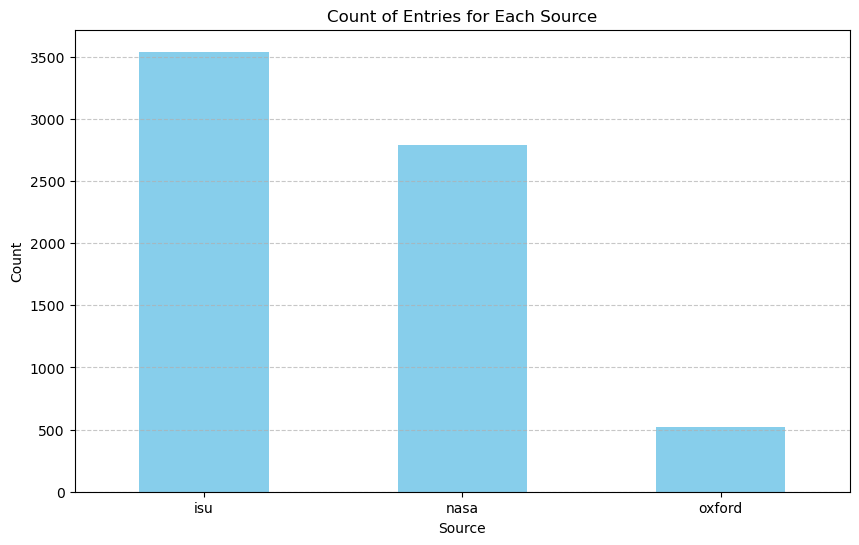

In [172]:
# Count the entries for each unique value in the 'source' column
source_counts = df_merged['source'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Entries for Each Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
def perform_eda(df, target_col='capacity', manual_bins=100):
    # Ensure numeric and clean
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # Correlation
    corr = df.corr(numeric_only=True)
    target_corr = corr[target_col].drop(target_col)
    target_corr = target_corr.replace([np.inf, -np.inf], np.nan).dropna()
    target_corr = target_corr.sort_values(ascending=False)

    ###########

    plt.figure(figsize=(10, 6))
    
    # Pastel green/red
    pastel_green = mcolors.to_rgba('#A8E6A3')
    pastel_red = mcolors.to_rgba('#F6A6A6')

    colors = target_corr.apply(lambda x: pastel_red if x < 0 else pastel_green)
    ax = target_corr.plot(kind='barh', color=colors)

    plt.title(f"Feature Correlation with Target: {target_col}", fontsize=14)
    plt.xlabel('Correlation Coefficient')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Add non-overlapping value labels
    for i, (value, label) in enumerate(zip(target_corr.values, target_corr.index)):
        offset = -0.035 if value >= 0 else 0.035
        ha = 'left' if value >= 0 else 'right'
        ax.text(value + offset, i, f"{value:.2f}", va='center', ha=ha, fontsize=9)

    plt.tight_layout()
    plt.show()

    # Histogram grid
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    n_cols = 4
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axs = axs.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axs[i]
        try:
            col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            sns.histplot(col_data, kde=True, ax=ax, bins=manual_bins)
            ax.set_title(f"Histogram of {col}", fontsize=10)
        except Exception as e:
            ax.set_title(f"{col} (Skipped)", fontsize=10)
            ax.text(0.5, 0.5, 'Plot Error', ha='center', va='center', fontsize=8)
            ax.axis('off')
            print(f"[Warning] Skipped '{col}' due to error: {e}")

    # Hide unused subplots
    for j in range(len(numeric_cols), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

    return target_corr


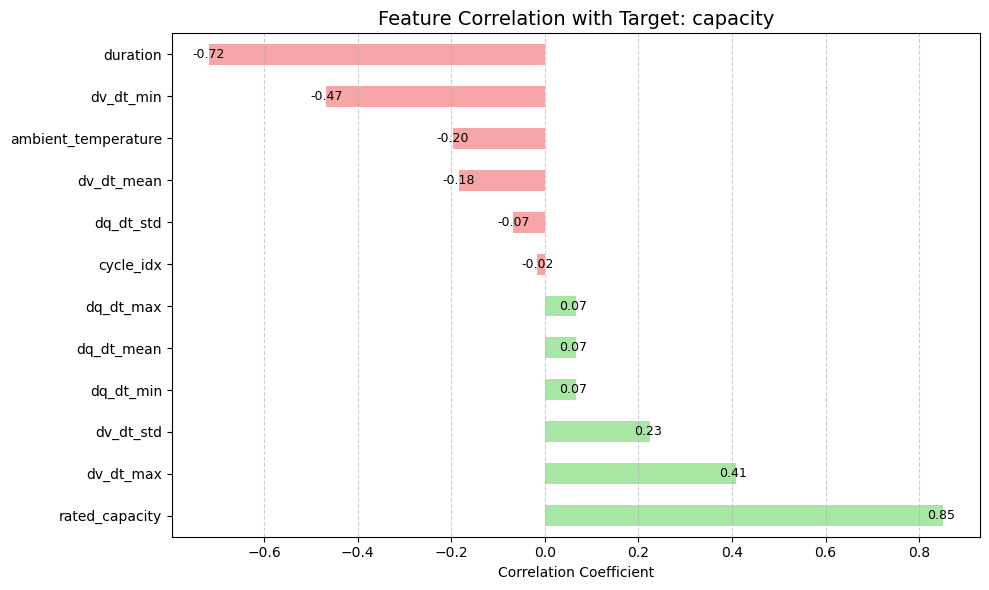

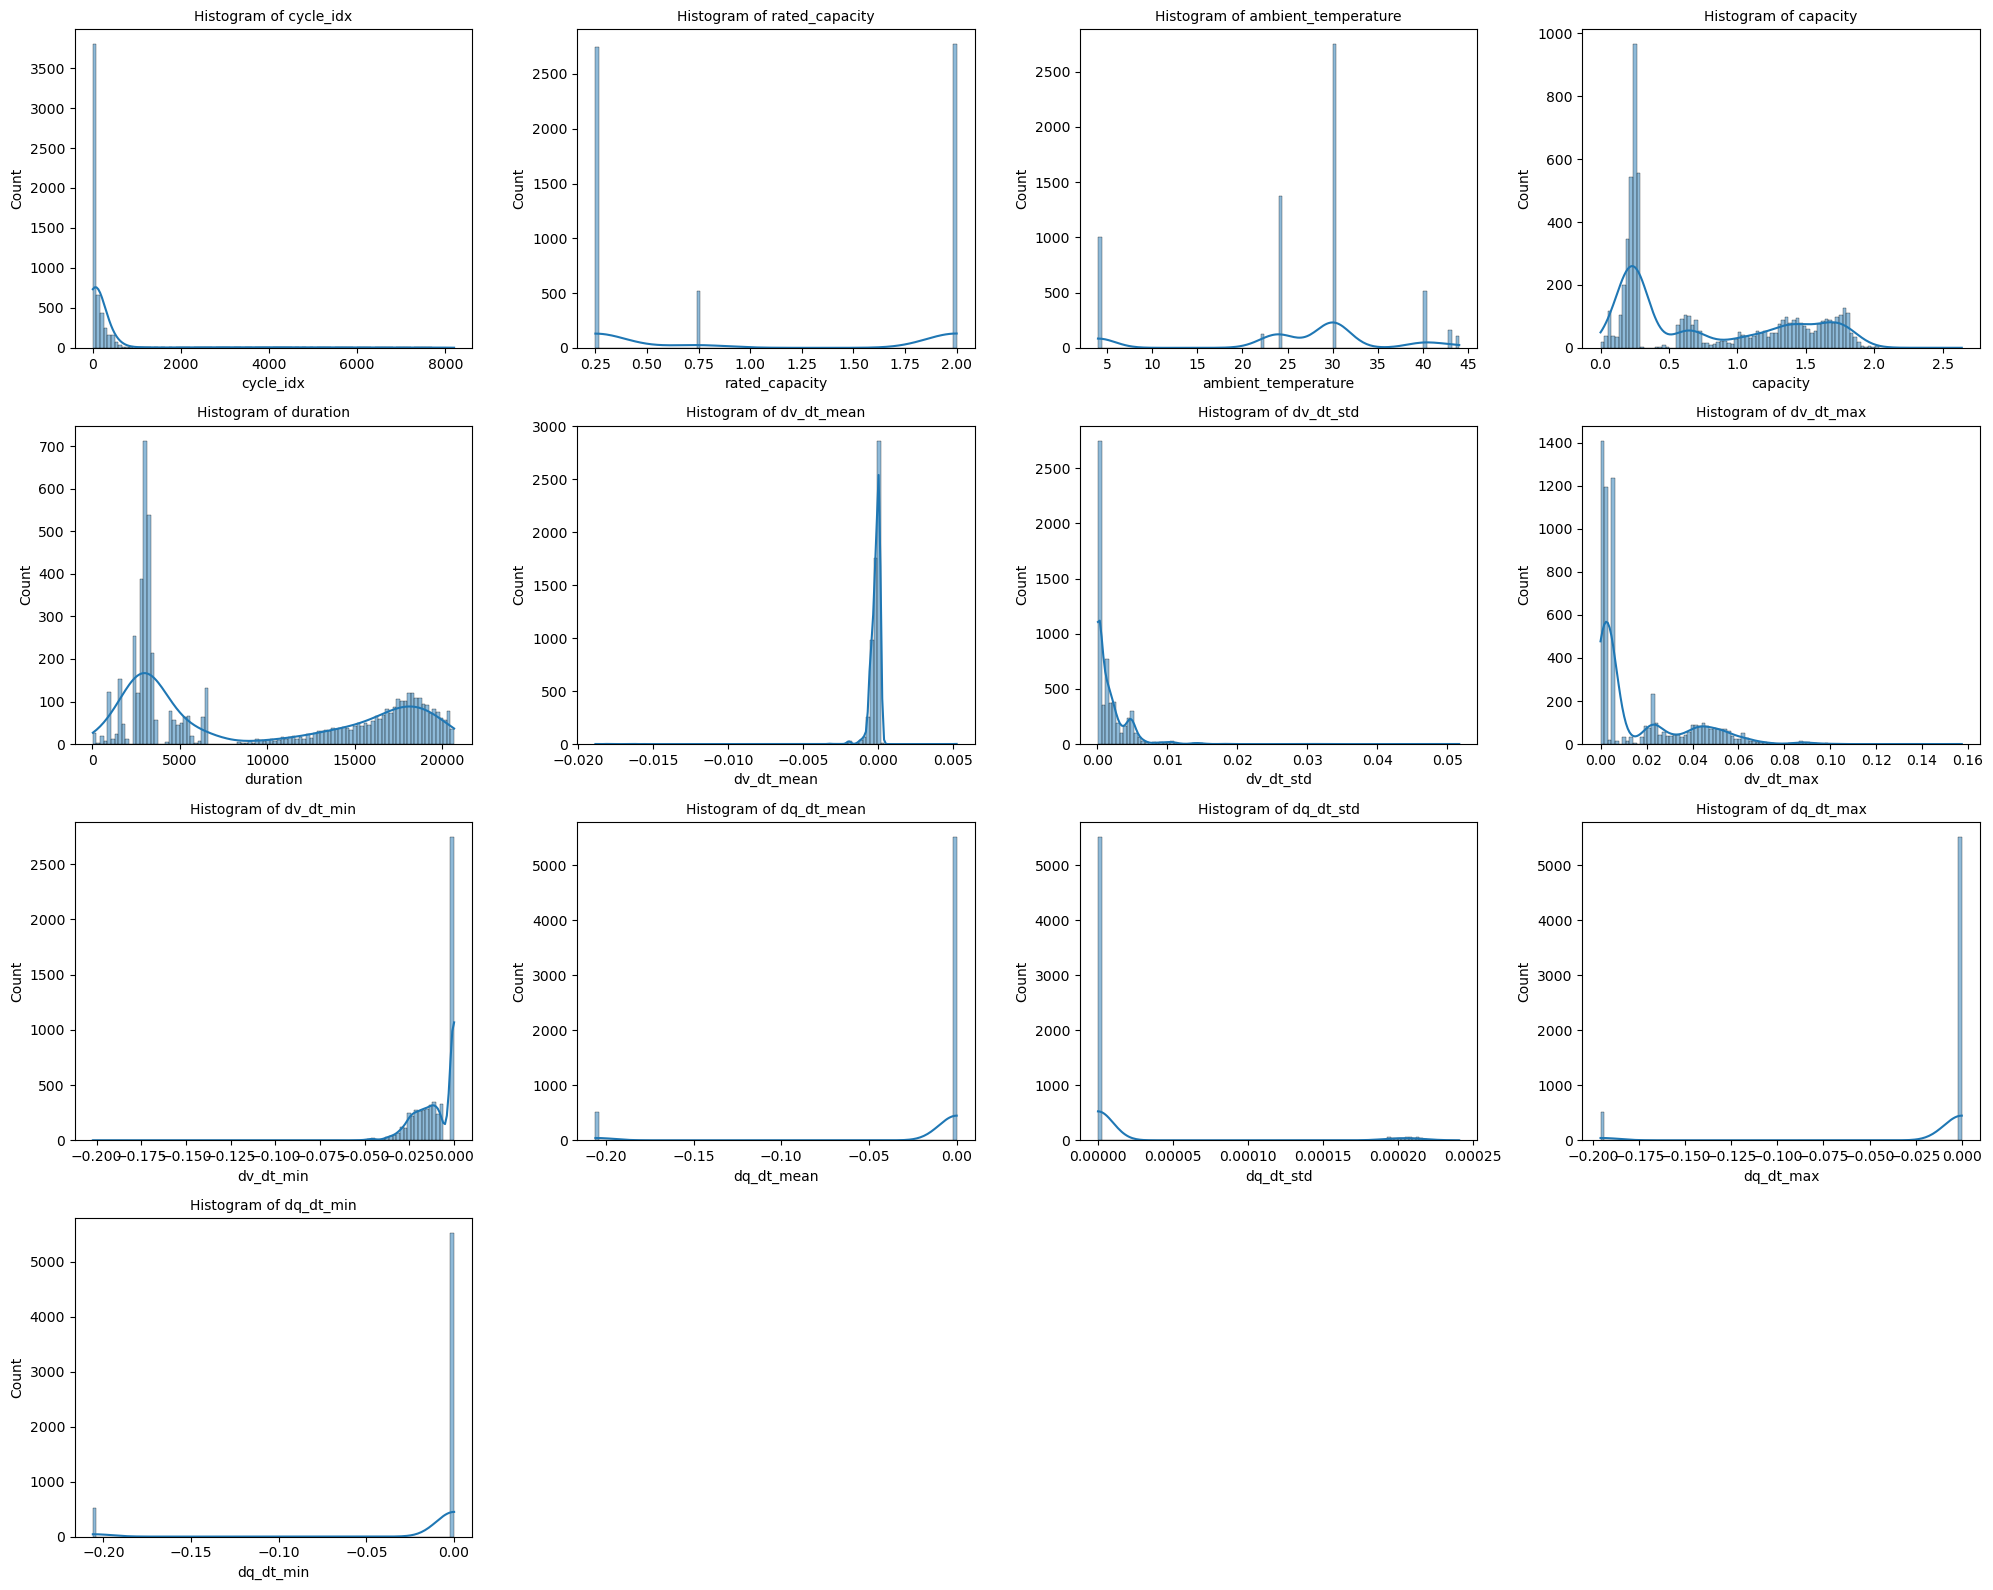

In [8]:
corr = perform_eda(df_merged_from_csv, target_col='capacity')

# C. Model training

In [9]:
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

## -- C.1 -- Model definition

In [175]:
# =================== MODELS ===================
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class FCNN_Dropout(nn.Module):
    def __init__(self, input_dim):
        super(FCNN_Dropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class FCNN_BatchNorm(nn.Module):
    def __init__(self, input_dim):
        super(FCNN_BatchNorm, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

## -- C.2 -- Train and compare

In [37]:
# =================== TRAIN FUNCTION ===================
def train_model_cv(df_all, model_class, target_col='capacity', epochs=50, batch_size=32, lr=0.001, folds=5):
    X = df_all.drop(columns=[target_col])
    y = df_all[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    all_train_mse, all_val_mse = [], []
    all_train_mae, all_val_mae = [], []
    all_train_r2, all_val_r2 = [], []
    infer_times = []

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    for train_idx, val_idx in tqdm(kf.split(X_scaled), total=folds, desc="Folds"):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if isinstance(model_class, type) and issubclass(model_class, nn.Module):
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

            train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
            model = model_class(input_dim=X_train.shape[1])
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            train_mse, val_mse = [], []
            train_mae, val_mae = [], []
            train_r2, val_r2 = [], []

            for _ in tqdm(range(epochs), desc="Epochs", leave=False):
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    loss = criterion(model(X_batch), y_batch)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    train_preds = model(X_train_tensor).numpy().flatten()
                    start_time = time.time()
                    val_preds = model(X_val_tensor).numpy().flatten()
                    infer_times.append(time.time() - start_time)
                    train_true = y_train_tensor.numpy().flatten()
                    val_true = y_val_tensor.numpy().flatten()

                    train_mse.append(mean_squared_error(train_true, train_preds))
                    val_mse.append(mean_squared_error(val_true, val_preds))
                    train_mae.append(mean_absolute_error(train_true, train_preds))
                    val_mae.append(mean_absolute_error(val_true, val_preds))
                    train_r2.append(r2_score(train_true, train_preds))
                    val_r2.append(r2_score(val_true, val_preds))

            all_train_mse.append(train_mse)
            all_val_mse.append(val_mse)
            all_train_mae.append(train_mae)
            all_val_mae.append(val_mae)
            all_train_r2.append(train_r2)
            all_val_r2.append(val_r2)

        else:
            model = model_class()
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            start_time = time.time()
            val_preds = model.predict(X_val)
            infer_times.append(time.time() - start_time)

            train_mse = [mean_squared_error(y_train, train_preds)] * epochs
            val_mse = [mean_squared_error(y_val, val_preds)] * epochs
            train_mae = [mean_absolute_error(y_train, train_preds)] * epochs
            val_mae = [mean_absolute_error(y_val, val_preds)] * epochs
            train_r2 = [r2_score(y_train, train_preds)] * epochs
            val_r2 = [r2_score(y_val, val_preds)] * epochs

            all_train_mse.append(train_mse)
            all_val_mse.append(val_mse)
            all_train_mae.append(train_mae)
            all_val_mae.append(val_mae)
            all_train_r2.append(train_r2)
            all_val_r2.append(val_r2)

    return {
        'train_mse': np.mean(all_train_mse, axis=0),
        'val_mse': np.mean(all_val_mse, axis=0),
        'train_mae': np.mean(all_train_mae, axis=0),
        'val_mae': np.mean(all_val_mae, axis=0),
        'train_r2': np.mean(all_train_r2, axis=0),
        'val_r2': np.mean(all_val_r2, axis=0),
        'infer_time': np.mean(infer_times)
    }

# =================== COMPARISON FUNCTION ===================
def compare_models(df_all, models_dict, metrics_to_plot=['mse', 'mae', 'r2']):
    results = {}
    summary_rows = []

    for name, model_class in models_dict.items():
        print(f"\n🚀 Training {name}...")
        res = train_model_cv(df_all, model_class)
        results[name] = res
        summary_rows.append({
            'Model': name,
            'Train MSE': np.mean(res['train_mse']),
            'Val MSE': np.mean(res['val_mse']),
            'Train MAE': np.mean(res['train_mae']),
            'Val MAE': np.mean(res['val_mae']),
            'Train R2': np.mean(res['train_r2']),
            'Val R2': np.mean(res['val_r2']),
            'Val Infer Time (s)': res['infer_time']
        })

    df_summary = pd.DataFrame(summary_rows)
    print("\n📊 Summary Table:")
    print(df_summary.to_string(index=False))

    num_models = len(models_dict)
    num_metrics = len(metrics_to_plot)
    fig, axs = plt.subplots(num_models, num_metrics, figsize=(5 * num_metrics, 4 * num_models), squeeze=False)

    for row_idx, (model_name, metrics) in enumerate(results.items()):
        for col_idx, metric in enumerate(metrics_to_plot):
            ax = axs[row_idx][col_idx]
            ax.plot(metrics[f'train_{metric}'], label='Train')
            ax.plot(metrics[f'val_{metric}'], label='Validation')
            ax.set_title(f"{model_name} - {metric.upper()}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(metric.upper())
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results


🚀 Training RandomForest...


Folds: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]



🚀 Training XGBoost...


Folds: 100%|██████████| 5/5 [00:00<00:00, 13.57it/s]



🚀 Training SVM...


Folds: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]



🚀 Training FCNN...


Folds: 100%|██████████| 5/5 [00:51<00:00, 10.24s/it]



🚀 Training FCNN_Dropout...


Folds: 100%|██████████| 5/5 [00:52<00:00, 10.49s/it]



🚀 Training FCNN_BatchNorm...


Folds: 100%|██████████| 5/5 [01:04<00:00, 12.83s/it]



🚀 Training LSTM...


Folds: 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]



🚀 Training GRU...


Folds: 100%|██████████| 5/5 [01:02<00:00, 12.54s/it]



🚀 Training Transformer...


Folds: 100%|██████████| 5/5 [02:51<00:00, 34.32s/it]



📊 Summary Table:
         Model  Train MSE  Val MSE  Train MAE  Val MAE  Train R2   Val R2  Val Infer Time (s)
  RandomForest   0.000397 0.002568   0.003993 0.010364  0.998951 0.993228            0.025543
       XGBoost   0.000030 0.001992   0.003165 0.011727  0.999921 0.994747            0.001463
           SVM   0.010954 0.011686   0.065439 0.066522  0.971042 0.969086            0.030397
          FCNN   0.006780 0.010809   0.037133 0.039180  0.982074 0.971477            0.000245
  FCNN_Dropout   0.010733 0.011846   0.055511 0.056497  0.971629 0.968658            0.000228
FCNN_BatchNorm   0.014133 0.017141   0.064341 0.065716  0.962632 0.954768            0.000283
          LSTM   0.013382 0.014610   0.055222 0.056582  0.964626 0.961349            0.001203
           GRU   0.014394 0.016201   0.058187 0.059666  0.961951 0.957148            0.000939
   Transformer   0.005243 0.005841   0.040106 0.040989  0.986142 0.984544            0.004730


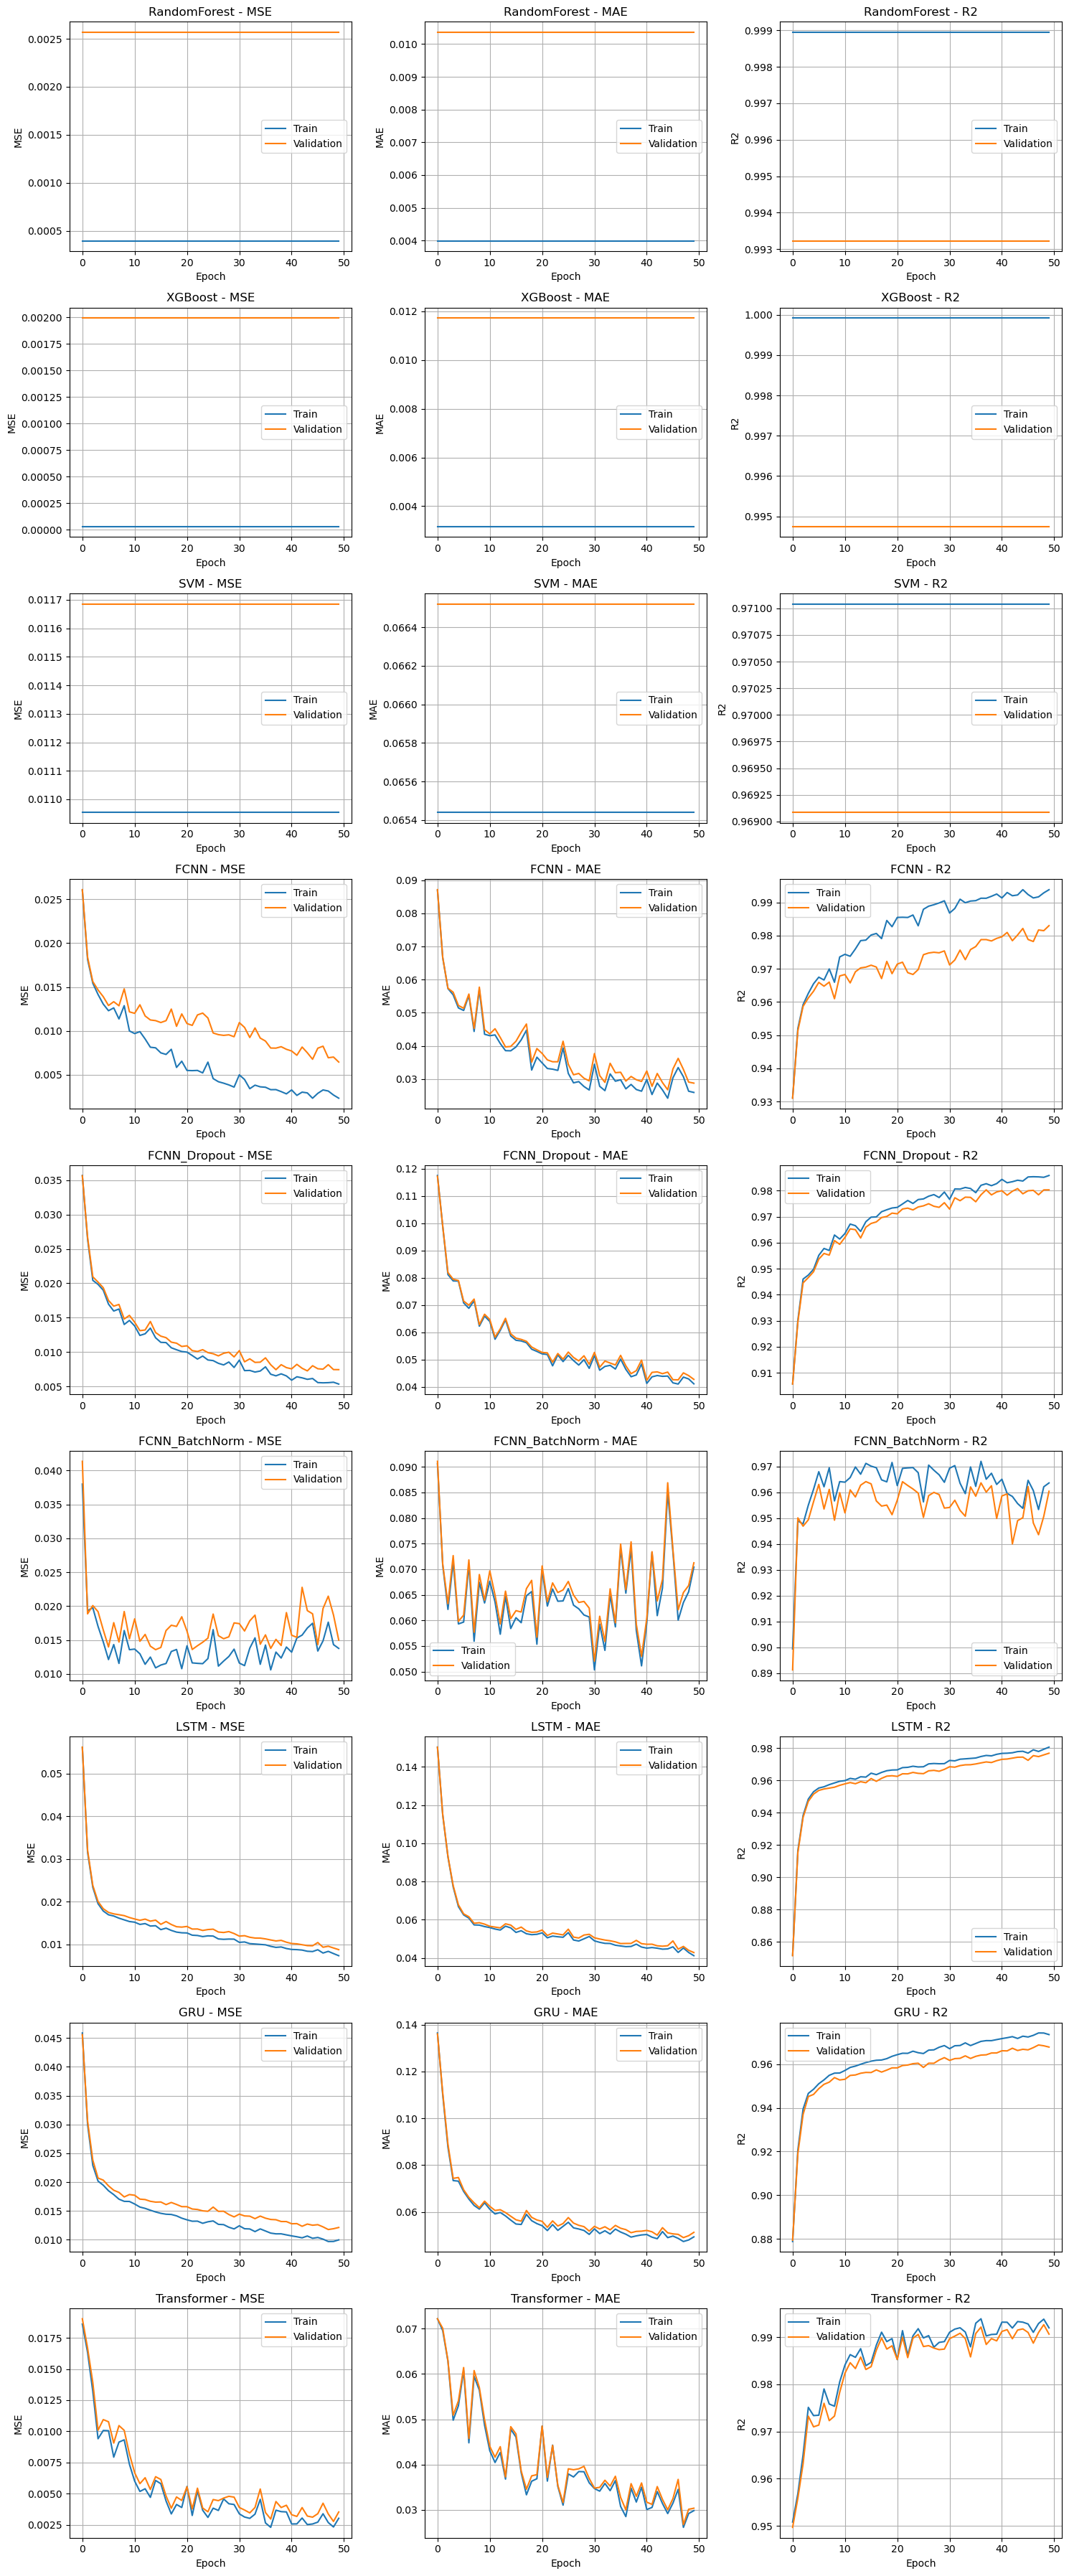

In [ ]:
models_to_test = {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor,
    'SVM': SVR,
    'FCNN': FCNN,
    'FCNN_Dropout': FCNN_Dropout,
    'FCNN_BatchNorm': FCNN_BatchNorm,
    'LSTM': LSTMModel,
    'GRU': GRUModel,
    'Transformer': SimpleTransformer,
}

results = compare_models(df_merged_from_csv, models_to_test, metrics_to_plot=['mse', 'mae', 'r2'])

## -- C.3 -- Incremental with same dataset

In [43]:
def run_incremental_vs_full_from_df(
    df, target_col, configs, test_size=0.2, init_split=0.5,
    epochs=100, patience=10, random_state=42
):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Convert single config to list
    if isinstance(configs, dict):
        configs = [configs]

    # === Preprocessing ===
    X = df.drop(columns=[target_col])
    y = df[target_col]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_init, X_incr, y_init, y_incr = train_test_split(X_train_all, y_train_all, test_size=init_split, random_state=random_state)

    def to_tensor(X, y):
        return torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    X_all_t, y_all_t = to_tensor(X_train_all, y_train_all)
    X_init_t, y_init_t = to_tensor(X_init, y_init)
    X_incr_t, y_incr_t = to_tensor(X_incr, y_incr)
    X_test_t, y_test_t = to_tensor(X_test, y_test)
    input_dim = X.shape[1]

    # === FCNN Model ===
    class FCNN(nn.Module):
        def __init__(self, input_dim, dropout=0.0):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)
            )
        def forward(self, x):
            return self.net(x)

    def evaluate(model, X, y):
        model.eval()
        with torch.no_grad():
            pred = model(X).squeeze().numpy()
        return {
            "MSE": mean_squared_error(y.numpy(), pred),
            "MAE": mean_absolute_error(y.numpy(), pred),
            "R²": r2_score(y.numpy(), pred)
        }

    def train(model, X_train, y_train, X_val, y_val, lr, weight_decay):
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        criterion = nn.MSELoss()
        history = {"train": {"MSE": [], "MAE": [], "R²": []}, "val": {"MSE": [], "MAE": [], "R²": []}}

        best_loss = float('inf')
        wait = 0
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward()
            optimizer.step()

            train_metrics = evaluate(model, X_train, y_train)
            val_metrics = evaluate(model, X_val, y_val)
            for m in ["MSE", "MAE", "R²"]:
                history["train"][m].append(train_metrics[m])
                history["val"][m].append(val_metrics[m])
            scheduler.step(val_metrics["MSE"])

            if val_metrics["MSE"] < best_loss:
                best_loss = val_metrics["MSE"]
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return model, history

    def plot_grid(histories):
        metrics = ["MSE", "MAE", "R²"]
        fig, axes = plt.subplots(len(histories), len(metrics), figsize=(5 * len(metrics), 4 * len(histories)))

        for row_idx, (tag, hist) in enumerate(histories.items()):
            for col_idx, metric in enumerate(metrics):
                ax = axes[row_idx, col_idx] if len(histories) > 1 else axes[col_idx]
                if "initial" in hist and "incremental" in hist:
                    ax.plot(hist["initial"]["val"][metric], label="Val Before")
                    ax.plot(hist["incremental"]["val"][metric], label="Val After")
                if "full" in hist:
                    ax.plot(hist["full"]["val"][metric], label="Full Only", linestyle="--")
                ax.set_title(f"{tag} - {metric}")
                ax.set_xlabel("Epoch")
                ax.set_ylabel(metric)
                ax.grid(True)
                if row_idx == 0 and col_idx == len(metrics) - 1:
                    ax.legend()
        plt.tight_layout()
        plt.show()

    # === Run each config ===
    all_histories = {}
    for i, cfg in enumerate(configs):
        tag = f"cfg_{i+1}_drop{cfg['dropout']}_lr{cfg['lr']}_wd{cfg['weight_decay']}"
        print(f"\n=== Running {tag} ===")

        # Incremental Training
        model = FCNN(input_dim, dropout=cfg["dropout"])
        model, h_init = train(model, X_init_t, y_init_t, X_test_t, y_test_t, lr=cfg["lr"], weight_decay=cfg["weight_decay"])
        torch.save(model.state_dict(), f"{tag}.pt")
        model = FCNN(input_dim, dropout=0.0)
        model.load_state_dict(torch.load(f"{tag}.pt"))
        model, h_incr = train(model, X_incr_t, y_incr_t, X_test_t, y_test_t, lr=cfg["lr"], weight_decay=cfg["weight_decay"])

        # Full-data Training
        model_full = FCNN(input_dim, dropout=cfg["dropout"])
        model_full, h_full = train(model_full, X_all_t, y_all_t, X_test_t, y_test_t, lr=cfg["lr"], weight_decay=cfg["weight_decay"])

        all_histories[tag] = {
            "initial": h_init,
            "incremental": h_incr,
            "full": h_full
        }

    plot_grid(all_histories)
    return all_histories


In [45]:
def summarize_final_metrics(histories):
    rows = []
    for tag, history in histories.items():
        row = {"Config": tag}
        for phase in ["initial", "incremental", "full"]:
            if phase in history:
                for metric in ["MSE", "MAE", "R²"]:
                    final_val = history[phase]["val"][metric][-1]
                    row[f"{phase}_{metric}"] = final_val
        rows.append(row)

    df_summary = pd.DataFrame(rows)
    df_summary = df_summary.set_index("Config")
    return df_summary



=== Running cfg_1_drop0.2_lr0.001_wd0.0001 ===


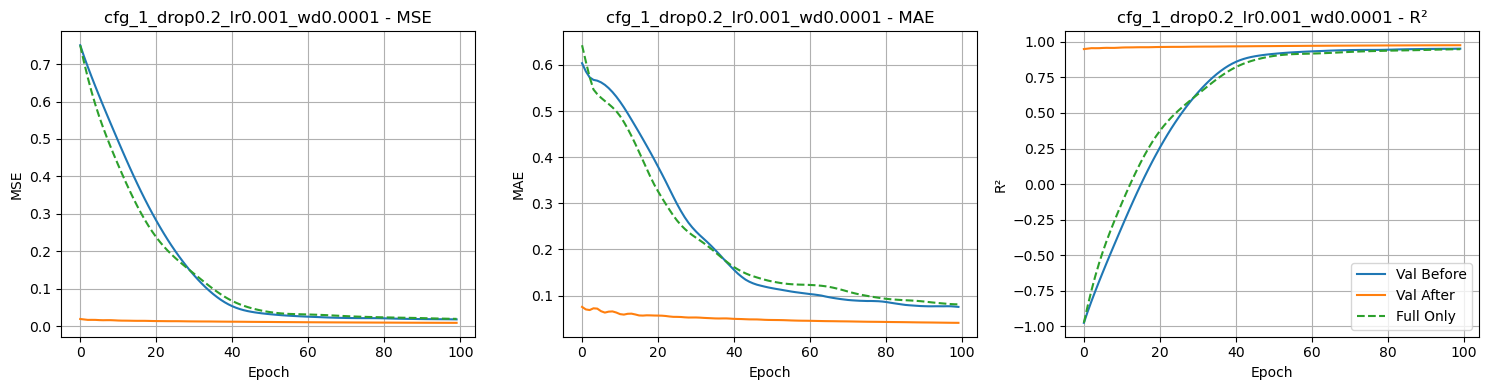

In [44]:
# Single config
config = {"lr": 0.001, "dropout": 0.2, "weight_decay": 1e-4}

results = run_incremental_vs_full_from_df(
    df=df_merged_from_csv.copy(),
    target_col="capacity",
    configs=config,
    test_size=0.2,
    init_split=0.5,
    epochs=100,
    patience=10
)


In [47]:
summary_incremental_samedata = summarize_final_metrics(results)
summary_incremental_samedata

initial_MSE  initial_MAE  initial_R²  \
Config                                                                 
cfg_1_drop0.2_lr0.001_wd0.0001     0.018188     0.075554    0.952128   

                                incremental_MSE  incremental_MAE  \
Config                                                             
cfg_1_drop0.2_lr0.001_wd0.0001         0.009012         0.040983   

                                incremental_R²  full_MSE  full_MAE   full_R²  
Config                                                                        
cfg_1_drop0.2_lr0.001_wd0.0001        0.976278  0.019632  0.080993  0.948327

## -- C.4 -- Staged incremental

In [161]:
def run_incremental_vs_full_stages(
    df_nasa, df_oxford, df_isu, df_merged, target_col,
    config, test_ratio=0.2, stage_train_ratio=0.2, match_rows=False,
    epochs=100, patience=10
):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import pandas as pd
    import matplotlib.pyplot as plt

    # Split df_merged: 80% for full model training, 20% for testing (shared)
    df_full_train, df_test_shared = train_test_split(df_merged, test_size=test_ratio, random_state=42)

    # === Dataset-Specific Staging Logic ===
    if match_rows:
        min_rows = min(len(df_nasa), len(df_oxford), len(df_isu))
        target_rows = int(min_rows * (stage_train_ratio if not isinstance(stage_train_ratio, dict) else 1.0))
        nasa_base, nasa_inc = df_nasa.iloc[:target_rows], df_nasa.iloc[target_rows:]
        oxford_base, oxford_inc = df_oxford.iloc[:target_rows], df_oxford.iloc[target_rows:]
        isu_base, isu_inc = df_isu.iloc[:target_rows], df_isu.iloc[target_rows:]
    else:
        if isinstance(stage_train_ratio, dict):
            nasa_ratio = stage_train_ratio.get("nasa", 0.2)
            oxford_ratio = stage_train_ratio.get("oxford", 0.2)
            isu_ratio = stage_train_ratio.get("isu", 0.2)
        else:
            nasa_ratio = oxford_ratio = isu_ratio = stage_train_ratio

        nasa_base, nasa_inc = train_test_split(df_nasa, train_size=nasa_ratio, random_state=42)
        oxford_base, oxford_inc = train_test_split(df_oxford, train_size=oxford_ratio, random_state=42)
        isu_base, isu_inc = train_test_split(df_isu, train_size=isu_ratio, random_state=42)

    # === Preprocessing ===
    scaler = StandardScaler().fit(df_full_train.drop(columns=[target_col]))

    def to_tensor(df):
        X_df = df.drop(columns=[target_col]).copy()
        y_df = df[target_col].copy()
        X_df = X_df.apply(pd.to_numeric, errors="coerce")
        y_df = pd.to_numeric(y_df, errors="coerce")
        valid = ~(X_df.isnull().any(axis=1) | y_df.isnull())
        X_df = X_df.loc[valid]
        y_df = y_df.loc[valid]
        X_scaled = scaler.transform(X_df)
        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_df.values, dtype=torch.float32).view(-1, 1)

    input_dim = df_full_train.drop(columns=[target_col]).shape[1]
    X_test_t, y_test_t = to_tensor(df_test_shared)

    # === Model Definition ===
    class FCNN(nn.Module):
        def __init__(self, input_dim, dropout=0.0):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 64), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(64, 1))
        def forward(self, x): return self.model(x)

    def evaluate(model, X, y):
        model.eval()
        with torch.no_grad():
            pred = model(X).squeeze().numpy()
        return {
            "MSE": mean_squared_error(y.numpy(), pred),
            "MAE": mean_absolute_error(y.numpy(), pred),
            "R2": r2_score(y.numpy(), pred)
        }

    def train(model, X_train, y_train, X_val, y_val, lr, wd):
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
        criterion = nn.MSELoss()
        best, wait = float('inf'), 0
        for _ in range(epochs):
            model.train()
            opt.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward(); opt.step()
            val_loss = criterion(model(X_val), y_val).item()
            scheduler.step(val_loss)
            if val_loss < best: best, wait = val_loss, 0
            else: wait += 1
            if wait >= patience: break
        return model

    # === Full Model Training ===
    X_full, y_full = to_tensor(df_full_train)
    full_model = FCNN(input_dim, dropout=config["dropout"])
    full_model = train(full_model, X_full, y_full, X_test_t, y_test_t, config["lr"], config["weight_decay"])
    full_metrics = evaluate(full_model, X_test_t, y_test_t)

    # === Incremental Model Training ===
    model = FCNN(input_dim, dropout=config["dropout"])
    df_stage_base = pd.concat([nasa_base, oxford_base, isu_base], ignore_index=True)
    X_base, y_base = to_tensor(df_stage_base)
    model = train(model, X_base, y_base, X_test_t, y_test_t, config["lr"], config["weight_decay"])

    stage_metrics = [("Initial_Stage_Base", evaluate(model, X_test_t, y_test_t))]
    stages = [
        ("NASA", nasa_inc),
        ("OXFORD", oxford_inc),
        ("ISU", isu_inc)
    ]

    for label, df_stage in stages:
        X_stage, y_stage = to_tensor(df_stage)
        model = train(model, X_stage, y_stage, X_test_t, y_test_t, config["lr"], config["weight_decay"])
        stage_metrics.append(("After_" + label, evaluate(model, X_test_t, y_test_t)))

    # === Summary Table ===
    records = []
    for label, metrics in stage_metrics:
        row = {
            "Stage": label,
            "MSE_stage": metrics["MSE"],
            "MAE_stage": metrics["MAE"],
            "R2_stage": metrics["R2"],
            "MSE_full": full_metrics["MSE"],
            "MAE_full": full_metrics["MAE"],
            "R2_full": full_metrics["R2"],
            "MSE_diff": metrics["MSE"] - full_metrics["MSE"],
            "R2_diff": metrics["R2"] - full_metrics["R2"]
        }
        records.append(row)

    df_summary = pd.DataFrame(records)

    # === Plot ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for i, metric in enumerate(["MSE_stage", "MAE_stage", "R2_stage"]):
        axs[i].plot(df_summary["Stage"], df_summary[metric], marker='o', label="Incremental")
        axs[i].hlines(full_metrics[metric.split('_')[0]], xmin=-0.5, xmax=len(stage_metrics)-0.5,
                     colors='orange', linestyles='--', label="Full")
        axs[i].set_title(metric.split('_')[0])
        axs[i].legend()
        axs[i].grid(True)
    plt.suptitle("Incremental vs Full Model Performance")
    plt.tight_layout()
    plt.show()

    return df_summary


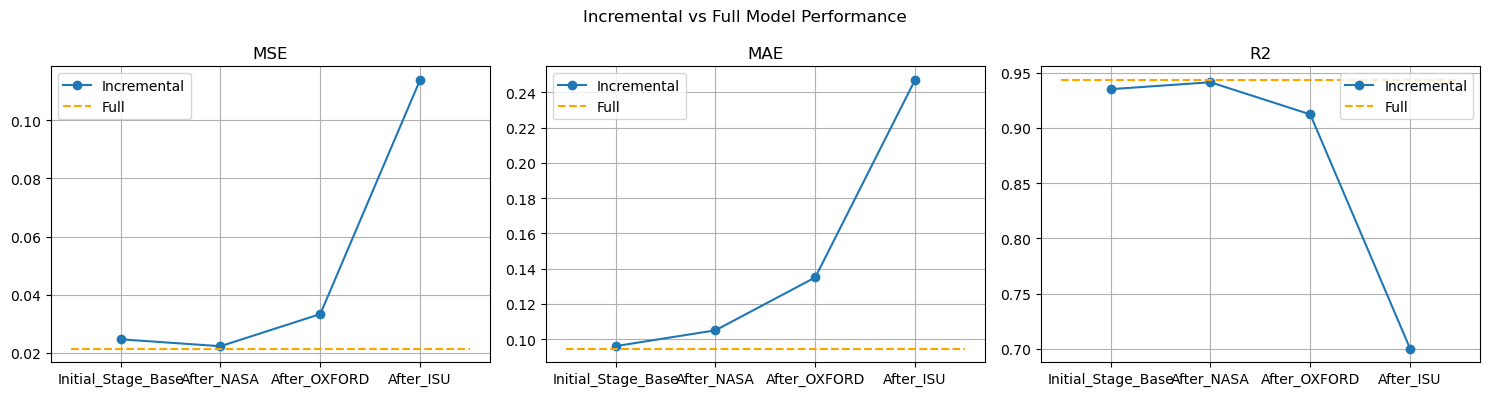

In [163]:
# Equal percent (20%) from each datase
summary = run_incremental_vs_full_stages(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config={"lr": 0.001, "dropout": 0.2, "weight_decay": 1e-4},
    test_ratio=0.2,
    stage_train_ratio=0.2,
    match_rows=False,
    epochs=100,
    patience=10
)


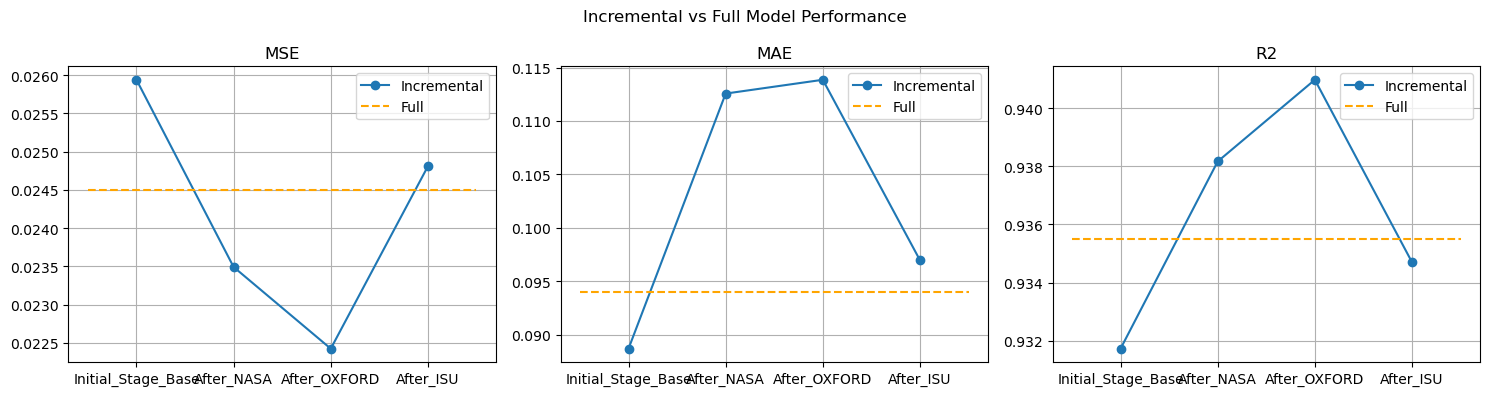

In [171]:
# Equal percent (20%) from each datase
summary = run_incremental_vs_full_stages(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config={"lr": 0.0007, "dropout": 0.0007, "weight_decay": 1e-8},
    test_ratio=0.2,
    stage_train_ratio=0.2,
    match_rows=False,
    epochs=100,
    patience=10
)

In [181]:
def run_incremental_vs_full_stages2(
    df_nasa, df_oxford, df_isu, df_merged, target_col,
    config, model_class, test_ratio=0.2, stage_train_ratio=0.2, match_rows=False,
    epochs=100, patience=10
):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import pandas as pd
    import matplotlib.pyplot as plt

    is_sequence_model = any(k in model_class.__name__.upper() for k in ["LSTM", "GRU", "TRANSFORMER"])

    df_full_train, df_test_shared = train_test_split(df_merged, test_size=test_ratio, random_state=42)

    if match_rows:
        min_rows = min(len(df_nasa), len(df_oxford), len(df_isu))
        target_rows = int(min_rows * (stage_train_ratio if not isinstance(stage_train_ratio, dict) else 1.0))
        nasa_base, nasa_inc = df_nasa.iloc[:target_rows], df_nasa.iloc[target_rows:]
        oxford_base, oxford_inc = df_oxford.iloc[:target_rows], df_oxford.iloc[target_rows:]
        isu_base, isu_inc = df_isu.iloc[:target_rows], df_isu.iloc[target_rows:]
    else:
        if isinstance(stage_train_ratio, dict):
            nasa_ratio = stage_train_ratio.get("nasa", 0.2)
            oxford_ratio = stage_train_ratio.get("oxford", 0.2)
            isu_ratio = stage_train_ratio.get("isu", 0.2)
        else:
            nasa_ratio = oxford_ratio = isu_ratio = stage_train_ratio

        nasa_base, nasa_inc = train_test_split(df_nasa, train_size=nasa_ratio, random_state=42)
        oxford_base, oxford_inc = train_test_split(df_oxford, train_size=oxford_ratio, random_state=42)
        isu_base, isu_inc = train_test_split(df_isu, train_size=isu_ratio, random_state=42)

    scaler = StandardScaler().fit(df_full_train.drop(columns=[target_col]))

    def to_tensor(df):
        X_df = df.drop(columns=[target_col]).copy()
        y_df = df[target_col].copy()
        X_df = X_df.apply(pd.to_numeric, errors="coerce")
        y_df = pd.to_numeric(y_df, errors="coerce")
        valid = ~(X_df.isnull().any(axis=1) | y_df.isnull())
        X_df = X_df.loc[valid]
        y_df = y_df.loc[valid]
        X_scaled = scaler.transform(X_df)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        if is_sequence_model:
            X_tensor = X_tensor.unsqueeze(1)  # (batch, seq_len=1, features)
        return X_tensor, torch.tensor(y_df.values, dtype=torch.float32).view(-1, 1)

    input_dim = df_full_train.drop(columns=[target_col]).shape[1]
    X_test_t, y_test_t = to_tensor(df_test_shared)

    def evaluate(model, X, y):
        model.eval()
        with torch.no_grad():
            pred = model(X).squeeze().numpy()
        return {
            "MSE": mean_squared_error(y.numpy(), pred),
            "MAE": mean_absolute_error(y.numpy(), pred),
            "R2": r2_score(y.numpy(), pred)
        }

    def train(model, X_train, y_train, X_val, y_val, lr, wd):
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
        criterion = nn.MSELoss()
        best, wait = float('inf'), 0
        for _ in range(epochs):
            model.train()
            opt.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward(); opt.step()
            val_loss = criterion(model(X_val), y_val).item()
            scheduler.step(val_loss)
            if val_loss < best: best, wait = val_loss, 0
            else: wait += 1
            if wait >= patience: break
        return model

    X_full, y_full = to_tensor(df_full_train)
    full_model = model_class(input_dim=input_dim, dropout=config["dropout"])
    full_model = train(full_model, X_full, y_full, X_test_t, y_test_t, config["lr"], config["weight_decay"])
    full_metrics = evaluate(full_model, X_test_t, y_test_t)

    model = model_class(input_dim=input_dim, dropout=config["dropout"])
    df_stage_base = pd.concat([nasa_base, oxford_base, isu_base], ignore_index=True)
    X_base, y_base = to_tensor(df_stage_base)
    model = train(model, X_base, y_base, X_test_t, y_test_t, config["lr"], config["weight_decay"])

    stage_metrics = [("Initial_Stage_Base", evaluate(model, X_test_t, y_test_t))]
    stages = [
        ("NASA", nasa_inc),
        ("OXFORD", oxford_inc),
        ("ISU", isu_inc)
    ]

    for label, df_stage in stages:
        X_stage, y_stage = to_tensor(df_stage)
        model = train(model, X_stage, y_stage, X_test_t, y_test_t, config["lr"], config["weight_decay"])
        stage_metrics.append(("After_" + label, evaluate(model, X_test_t, y_test_t)))

    records = []
    for label, metrics in stage_metrics:
        row = {
            "Stage": label,
            "MSE_stage": metrics["MSE"],
            "MAE_stage": metrics["MAE"],
            "R2_stage": metrics["R2"],
            "MSE_full": full_metrics["MSE"],
            "MAE_full": full_metrics["MAE"],
            "R2_full": full_metrics["R2"],
            "MSE_diff": metrics["MSE"] - full_metrics["MSE"],
            "R2_diff": metrics["R2"] - full_metrics["R2"]
        }
        records.append(row)

    df_summary = pd.DataFrame(records)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for i, metric in enumerate(["MSE_stage", "MAE_stage", "R2_stage"]):
        axs[i].plot(df_summary["Stage"], df_summary[metric], marker='o', label="Incremental")
        axs[i].hlines(full_metrics[metric.split('_')[0]], xmin=-0.5, xmax=len(stage_metrics)-0.5,
                     colors='orange', linestyles='--', label="Full")
        axs[i].set_title(metric.split('_')[0])
        axs[i].legend()
        axs[i].grid(True)
    plt.suptitle("Incremental vs Full Model Performance")
    plt.tight_layout()
    plt.show()

    return df_summary



=== FCNN ===


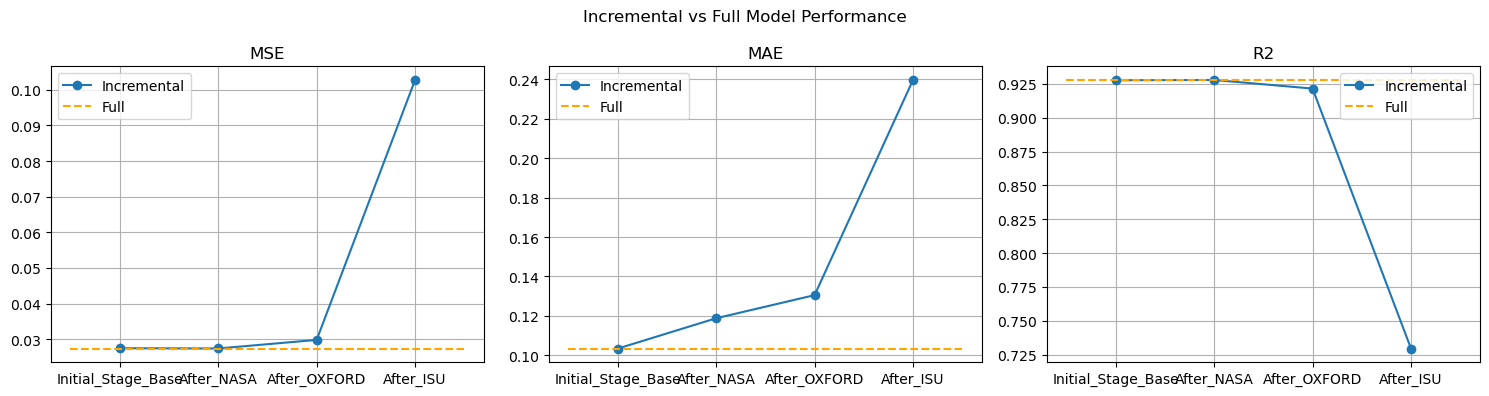


=== LSTM ===


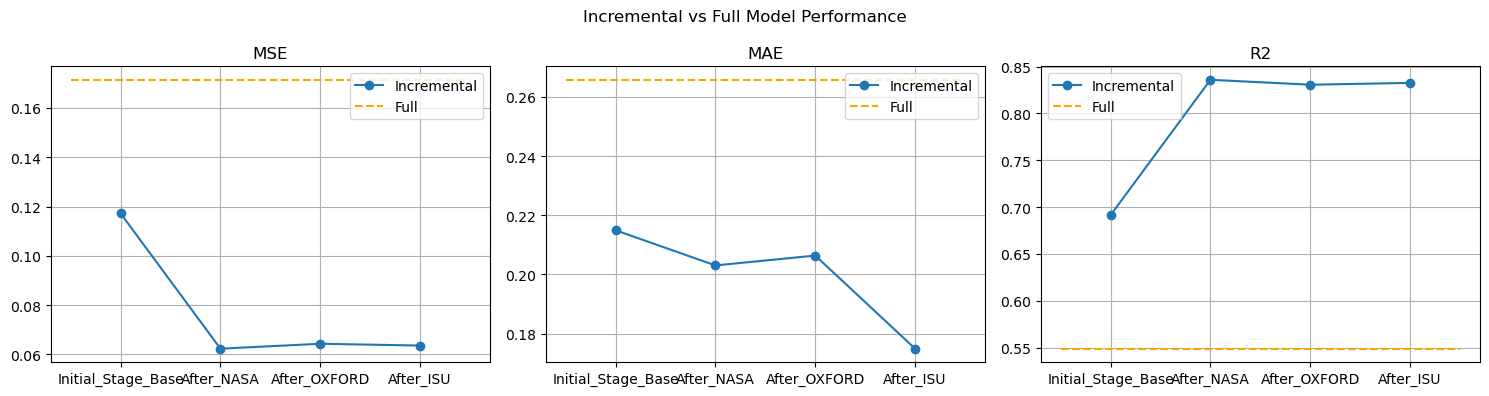


=== GRU ===


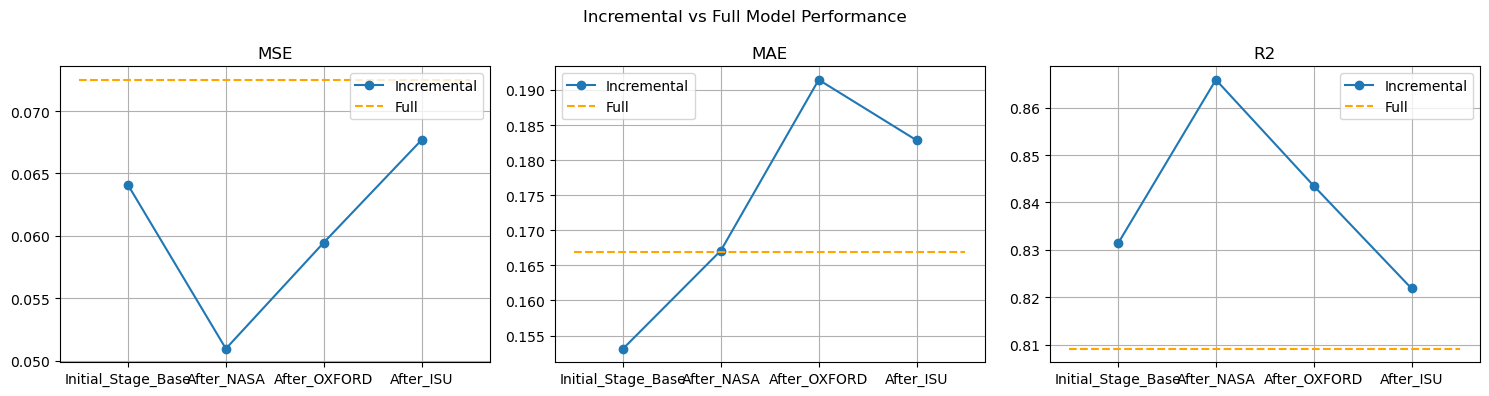


=== Transformer ===


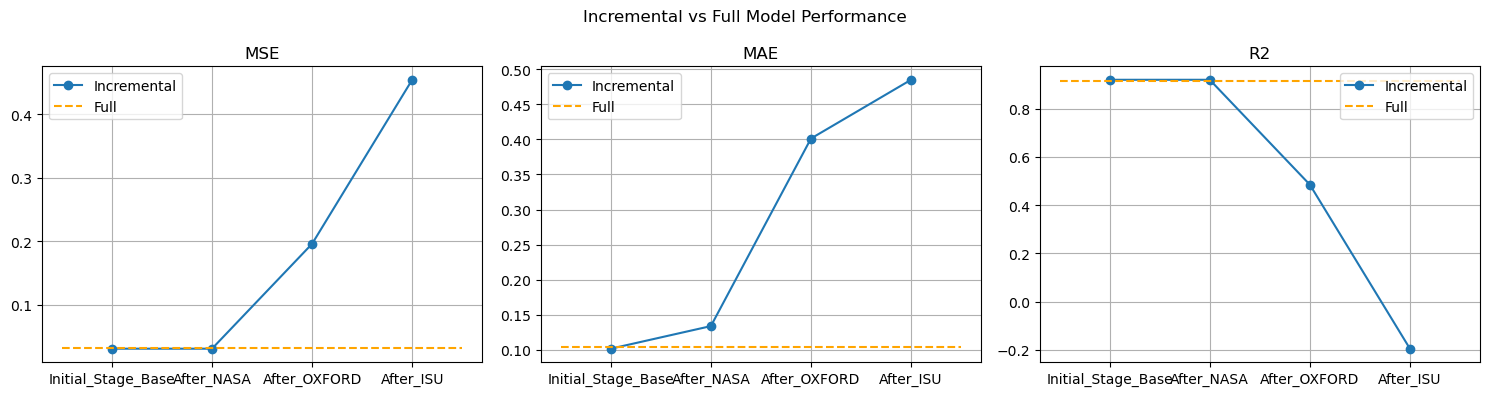

In [183]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True)
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1])

class GRUModel(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_dim, 64, batch_first=True)
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.gru(x)
        return self.head(out[:, -1])
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim, dropout=0.2, nhead=4, num_layers=2, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch, seq_len=1, input_dim)
        x = self.embedding(x)          # (batch, 1, hidden_dim)
        x = self.transformer(x)        # (batch, 1, hidden_dim)
        return self.head(x[:, -1])     # take the last time step


config = {"lr": 0.001, "dropout": 0.2, "weight_decay": 1e-4}

# FCNN
print("\n=== FCNN ===")
summary_fcnn = run_incremental_vs_full_stages2(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config=config,
    model_class=FCNN
)

# LSTM
print("\n=== LSTM ===")
summary_lstm = run_incremental_vs_full_stages2(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config=config,
    model_class=LSTMModel
)

# GRU
print("\n=== GRU ===")
summary_gru = run_incremental_vs_full_stages2(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config=config,
    model_class=GRUModel
)

# Transformer
print("\n=== Transformer ===")
summary_transformer = run_incremental_vs_full_stages2(
    df_nasa=nasa_df_from_csv_increment,
    df_oxford=oxford_df_from_csv_increment,
    df_isu=isu_df_from_csv_increment,
    df_merged=df_merged_from_csv,
    target_col="capacity",
    config={"lr": 0.001, "dropout": 0.2, "weight_decay": 1e-4},
    model_class=TransformerModel,
    test_ratio=0.2,
    stage_train_ratio=0.2,
    match_rows=False,
    epochs=100,
    patience=10
)
